# Math Lectures
### Unit 4 Capstone (Thinkful Data Science)
This notebook examines math lectures on the lecture level. The lectures are vectorized using Doc2Vec

In [89]:
import os
import time
from collections import Counter, OrderedDict
from itertools import islice
import smart_open

import numpy as np
import pandas as pd
import scipy
import spacy
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import xml.etree.ElementTree as ET  

import re
import nltk
from nltk.corpus import stopwords
from nltk.cluster import KMeansClusterer
from nltk.tokenize import word_tokenize
import gensim
from gensim.models import word2vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn import cluster, ensemble, linear_model, naive_bayes, neighbors, svm
from sklearn.model_selection import cross_val_score, train_test_split, ShuffleSplit


from sklearn.decomposition import TruncatedSVD, NMF, PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer, minmax_scale

from sklearn.metrics import classification_report,confusion_matrix,roc_curve,auc, silhouette_score
from sklearn.metrics.pairwise import cosine_similarity


import warnings
warnings.filterwarnings(
    module='gensim',
    action='ignore',
    message='Conversion')
warnings.filterwarnings(
    module='scipy',
    action='ignore',
    message='Using a')
warnings.filterwarnings("ignore",category=DeprecationWarning)


default_stopwords = set(nltk.corpus.stopwords.words('english'))
stemmer = nltk.stem.snowball.SnowballStemmer('english')
sns.set(style='dark',context='paper',palette='BrBG_r')
%matplotlib inline


 
def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

In [3]:
glob_time1 = time.time()

### Importing the data
    - The texts consist of the closed captioning for 93 lectures on varying topics in mathematics, computer science, and engineering
    - The XML files were accessed through the console in a web browser and saved as XML 

In [4]:
#set path to XML files
path = '/lectures'
folder = os.fsencode(path)

#get list of the filenames
filenames = sorted([re.sub('.xml','',os.fsdecode(file)) for file in os.listdir(folder)])
\

#Use ElementTree trace xml tree and extract text from xml files, removing tags
lecture_texts = []
for file in filenames:
    tree = ET.parse('lectures/{}.xml'.format(file))
    root = tree.getroot()
    all_text = []
    for elem in root:  
        for subelem in elem:
            all_text.append(subelem.text)
    lecture_texts.append(all_text)

In [5]:
#check some text from a random lecture
lecture_texts[47][30:35]

['the most common change of\nvariables is the one simple one',
 'called scaling.\nSo, again, the kind of equation',
 "I'm talking about is a general\nfirst-order equation.",
 'And, scaling simply means to\nchange the coordinates,',
 'in effect, or axes,\nto change the coordinates on']

In [6]:
#create a DataFrame for records
raw_data = pd.DataFrame()
raw_data['filename'] = filenames
raw_data['raw_text'] = [ ' '.join(i) for i in lecture_texts ] #unpack list of lists as string
print(type(raw_data.raw_text[0]))
raw_data.head(1)

<class 'str'>


,filename,raw_text
0,aurouxmcalc1,So let's start right away with\nstuff that we ...


### Cleaning the text

Now we will clean the text removing '\n', the intros (MIT has a long intro), the professor names and other undesirable punctuation etc. Also, we want to replace contractions with thier full counterparts.

In [7]:
#Function to remove identified words through visual inspection
def text_cleaner(text):
    text = re.sub(r'--',', ',text) # unrecognized punctuation
    text = re.sub("[\[].*?[\]]", "", text) #remove in [audible],[laughter] etc
    text = ' '.join(text.split()) #for one long string
    #remove intros,professor names
    text = re.sub("The following content is provided under a Creative Commons license. ",'',text)
    text = re.sub('Your support will help MIT OpenCourseWare continue to',' ',text)
    text = re.sub(' offer high quality educational resources for free.',' ',text)
    text = re.sub('To make a donation or ',' ',text)
    text = re.sub('view additional materials from hundreds of MIT',' ',text)   
    text = re.sub(' courses, visit MIT OpenCourseWare at ocw.mit.edu.',' ',text)   
    text = re.sub('Haynes Miller','PROFESSOR',text)
    text = re.sub('David Jerison','PROFESSOR',text)
    text = re.sub('Srini Devadas','PROFESSOR',text)
    text = re.sub('Gilbert Strang','PROFESSOR',text)
    text = re.sub('TOM LEIGHTON','PROFESSOR',text)
    text = re.sub('PHILIPPE RIGOLLET','PROFESSOR',text)
    text = re.sub('PROFESSOR STRANG','PROFESSOR',text)
    text = re.sub('PROF. PATRICK WINSTON','PROFESSOR',text)
    text = re.sub('PROFESSOR PATRICK WINSTON','PROFESSOR',text)   
    text = re.sub('ERIK DEMAINE','PROFESSOR',text)
    text = re.sub('Demaine','PROFESSOR',text)
    text = re.sub('Erik','PROFESSOR',text)
    text = re.sub('PROF. JERISON','PROFESSOR',text)
    text = re.sub('ERIK DOMANE','PROFESSOR',text)
    text = re.sub('Erik Domane','PROFESSOR',text)
    text = re.sub('Stanford University. >>', '',text)
    text = re.sub('PATRICK WINSTON', 'PROFESSOR',text)
    text = re.sub('Welcome to 6.851 Advanced Data Structures', 'PROFESSOR',text)
    text = re.sub('PROFESSOR: PROFESSOR', ' ',text)
    text = re.sub('PROFESSOR PROFESSOR', ' ',text)
    return text

#list common contractions and full text counterpart
contractions_dict = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "does'nt": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he has",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "I'd": "I would",
  "I'd've": "I would have",
  "I'll": "I will",
  "I'll've": "I will have",
  "I'm": "I am",
  "I've": "I have",
  "isn't": "is not",
  "it'd": "it would",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she had / she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "tellin": 'telling',
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "thats": "that is",
  "there'd": "there would",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we would",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "ya": "you",
  "y'all": "you all",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had / you would",
  "you'd've": "you would have",
  "you'll": "you shall / you will",
  "you'll've": "you will have",
  "you're": "you are",
  "you've": "you have"}
#function to correct the contractions
contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))
def expand_contractions(s, contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, s)


In [8]:
raw_data.raw_text = [ expand_contractions(i) for i in raw_data.raw_text]
raw_data.raw_text = [ text_cleaner(i) for i in raw_data.raw_text]

In [9]:
#label professors
raw_data['Professor'] = ['Auroux']*4 + ['Demaine']*7 + ['Devadas']*9 + ['Jerison']*9 + ['Leighton']*11 + ['Manning']*3 + ['Mattuck']*9\
+ ['Rigollet']*10 + ['Socher']*4 + ['Strang']*18 + ['Winston']* 8
#label_subjects
raw_data['Subject'] = ['Calculus']*4 + ['Data']*7 + ['Algorithms']*9 + ['Calculus']*9 + ['CS Math']*11 + ['NLP']*3\
+ ['Diff. Eq.']*9+ ['Statistics']*10 + ['NLP']*4 + ['Linear Algebra']*10 + ['Mech. Eng']* 8 +\
['AI']*8
raw_data.head(5)

,filename,raw_text,Professor,Subject
0,aurouxmcalc1,So let us start right away with stuff that we ...,Auroux,Calculus
1,aurouxmcalc11,to So far we have learned about partial...,Auroux,Calculus
2,aurouxmcalc2,"So , So, yesterday we learned about the questi...",Auroux,Calculus
3,aurouxmcalc5,"to So, so far, we have seen things abou...",Auroux,Calculus
4,demainedata1,. I am . You can call me PROFESSOR. W...,Demaine,Data


### Tokenization with spacy

Here we will parse the text using spacy and append each spacy object (each lecture) to the dataframe.
Then we will create a new data frame with the professor, subject, filename and the spacy doc.
We will use a list comprehension to tokenize each sentences from each lecture and append the list of lists to the dataframe.
Then we will drop the spacy doc, we will -explode- the data frame so that each sentence is an observation, while maintaining tracability to the lecture level.
We will also take the sentence length for further sentence elimination.

In [10]:
#Create Spacy document for each lecture
t1 = time.time()
nlp = spacy.load('en')
raw_data['sdoc'] = [nlp(i) for i in raw_data.raw_text]
print('Minutes: {}'.format((time.time()-t1)/60))

Minutes: 3.809774406750997


In [11]:
#more cleaning
def clean_lite (text):
    re.sub("-pron-",'',text)
    return text    

In [12]:
#create a new data frame for the professor,subject and the spacy doc
sentences = raw_data[['filename','Professor','Subject','sdoc']].copy()

#create a list of lists of tokens (remove stop words and punct) 
sentences['sents'] = [ [ [token.lemma_.lower() for token in sent if not token.is_stop
        and not token.is_punct] for sent in doc.sents] for doc in sentences.sdoc]

#convert lecture lists of sentences to lecture string
sentences['text'] = [' '.join([str( ' '.join(i)) for i in j]) for j in sentences.sents]

sentences['text'] = [ ' '.join(pd.Series(sentences.text[i]).str.replace('-pron-',''))\
                     for i in range(len(sentences.text)) ]

In [13]:
sentences.to_csv('sentences.csv')
sentences.head()

,filename,Professor,Subject,sdoc,sents,text
0,aurouxmcalc1,Auroux,Calculus,"(So, let, us, start, right, away, with, stuff,...","[[so, let, start, right, away, stuff, need, ad...",so let start right away stuff need advanced th...
1,aurouxmcalc11,Auroux,Calculus,"( , to, , So, far, we, have, learned, ab...","[[ , ], [so, far, learn, partial, deriva...",so far learn partial derivative use f...
2,aurouxmcalc2,Auroux,Calculus,"(So, ,, So, ,, yesterday, we, learned, about, ...","[[so, so, yesterday, learn, question, plane, t...",so so yesterday learn question plane think 3x3...
3,aurouxmcalc5,Auroux,Calculus,"( , to, , So, ,, so, far, ,, we, have, s...","[[ , ], [so, far, see, thing, vector, eq...",so far see thing vector equation plan...
4,demainedata1,Demaine,Data,"( , ., I, am, , ., You, can, call, me,...","[[ ], [-pron-, ], [-pron-, professor],...",professor ta tom morgan justin z...


In [14]:
#Split the data exactly the way it was previously split
X = np.array(sentences['text'])
y = np.array(sentences[['filename','Professor','Subject']]) #keep both labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=43)
X_train.shape

(69,)

In [15]:
#The Doc2Vec takes a tagged document as the input,with the tokenized sentences and an identification tag.

In [16]:
#tag the data
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(X_train)]

In [17]:
'''#Train the model

#max training epochs
max_epochs = 100

model = Doc2Vec(vector_size=65, # lower dimensions than observations
                alpha=.025, #initial learning rate
                min_alpha=0.00025, #learning rate drops linearly to this
                min_count=7, #ignores all words with total frequency lower than this.
                dm =1) #algorith 1=distributed memory

#Build vocabulary from a sequence of sentences (can be a once-only generator stream).
model.build_vocab(tagged_data)

#train 100 epochs and save the model
t1 = time.time()
for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.iter)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha
t2 = time.time()    
model.save("full_lects.model")
print("Model Saved")
print("Time: {}".format(t2-t1))'''

'#Train the model\n\n#max training epochs\nmax_epochs = 100\n\nmodel = Doc2Vec(vector_size=65, # lower dimensions than observations\n                alpha=.025, #initial learning rate\n                min_alpha=0.00025, #learning rate drops linearly to this\n                min_count=7, #ignores all words with total frequency lower than this.\n                dm =1) #algorith 1=distributed memory\n\n#Build vocabulary from a sequence of sentences (can be a once-only generator stream).\nmodel.build_vocab(tagged_data)\n\n#train 100 epochs and save the model\nt1 = time.time()\nfor epoch in range(max_epochs):\n    print(\'iteration {0}\'.format(epoch))\n    model.train(tagged_data,\n                total_examples=model.corpus_count,\n                epochs=model.iter)\n    # decrease the learning rate\n    model.alpha -= 0.0002\n    # fix the learning rate, no decay\n    model.min_alpha = model.alpha\nt2 = time.time()    \nmodel.save("full_lects.model")\nprint("Model Saved")\nprint("Time: {

In [18]:
#load the saved model
model = Doc2Vec.load("full_lects.model")

In [19]:
X_train.shape
print(model.docvecs['40'])

[-0.8321664   0.6536642  -4.6717925   1.5663195  -0.64231473  3.16808
 -4.415416   -1.2429427  -0.6726822  -0.2637057   1.3834563   1.9255236
  4.345558    0.9103465  -2.0931695   0.73952943  5.210343   -4.912125
  0.5291028  -6.348429   -0.37202114 -0.22772527  5.8318787  -3.1300318
 -4.264407   -6.38189     1.9507649   4.8407845  -0.51151556  0.06365214
 -1.2860419  -5.941807    1.7796606   7.4478865   4.9785905   3.0708725
 -3.9537046  -0.34952983 -5.0308824   0.01304174 -0.7503292   2.4075284
  1.5697635  -0.7096595   0.46374488 -1.0662848   3.8872757   3.568486
 -2.3832762   0.33145884 -0.72271574  3.5132866   0.3877602  -8.248993
 -2.4241836   1.8217995   2.9689164  -0.48466983  0.8185435  -2.32856
  4.9923024   0.26991034  4.4564238  -7.9614573  -1.2868713 ]


In [20]:
len(tagged_data)

69

In [21]:
#view some of the text and its vector representation
print(tagged_data[0][0][:25])

['all', 'right', 'hello', 'everybody', 'welcome', 'lecture', 'seven', 'maybe', 'definitely', 'today', 'beginning', 'talk', 'model', 'matter', 'practice', 'will', 'talk', 'today', 'simple', 'recurrent', 'neural', 'network', 'model', 'think', 'but']


In [22]:
#extract the vectors from the model 
vecs = pd.DataFrame([model.docvecs[str(i)] for i in range(len(tagged_data))])

In [23]:
vecs.head()

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,2.662631,1.020528,6.387894,-5.270965,-3.704841,-0.420956,2.778944,5.019346,-4.486396,-2.107513,...,3.396559,3.060336,-4.802394,0.786580,-0.386007,0.646909,-4.432489,-3.879818,-4.344139,6.839713
1,-2.337144,-0.877562,-2.179196,3.026798,2.296631,2.526698,-3.398579,-2.706168,-0.723500,-3.683723,...,0.562401,3.384104,-1.825595,4.098755,-7.520695,2.432416,-0.412479,-3.832665,-2.355965,4.235193
2,-1.693762,1.025025,-6.552120,0.428101,-0.465139,5.433910,0.244512,-3.862596,0.788520,-8.810690,...,-1.666339,0.638123,2.022471,1.041324,-0.160084,2.060118,-1.334408,-7.250730,0.414432,-3.088844
3,2.106681,2.410404,1.423349,-0.458352,-4.432656,-1.351960,-4.553487,-4.567388,0.558583,0.871899,...,-1.446398,-1.129746,2.364754,3.316131,1.096824,-1.850198,3.108307,-5.812174,1.806449,1.027032
4,2.490935,-7.870018,3.407579,5.935986,1.284999,4.579460,-3.233096,-3.997610,-1.596189,-1.476011,...,2.666141,1.281831,4.023477,1.412699,2.011926,5.490794,-4.224072,0.205075,-2.344938,-6.776477


In [24]:
d2v_fullsim = pd.DataFrame(cosine_similarity(vecs), index=y_train[:,0], columns=y_train[:,0])

In [25]:
d2v_fullsim.insert(0, 'mean_similarity', d2v_fullsim.mean(axis=1))

In [26]:
d2v_fullsim.to_csv('d2v_fullsim.csv')

In [25]:
### Calculate Similarity of lectures in the Doc2Vec model 

In [27]:
#add identification to similarity dataframe
d2v_fullsim['Professor'] = y_train[:,1]
d2v_fullsim['Subject'] = y_train[:,2]
d2v_fullsim['Original_Sentence'] = X_train
d2v_fullsim['filenames'] = y_train[:,0]

In [79]:
lecture = y_train[:,0][10]
d2v_fullsim[[lecture, 'Original_Sentence', 'Professor','Subject',
             'filenames','mean_similarity']].sort_values(by=[lecture],ascending=False)[:15]

,winstonai10,Original_Sentence,Professor,Subject,filenames,mean_similarity
winstonai10,1.000000,professor well kodo drummers be group 30 40 j...,Winston,AI,winstonai10,0.152805
winstonai1,0.409383,professor welcome 6034 know deal microphone ...,Winston,AI,winstonai1,0.164274
winstonai2,0.391339,what go talk today goal so way little warm exe...,Winston,AI,winstonai2,0.139733
jerisonmillercalc4,0.322280,to donation course visit mit opencourse...,Jerison,Calculus,jerisonmillercalc4,0.188756
winstonai7,0.298507,professor many maybe work search problem hand ...,Winston,AI,winstonai7,0.150191
jerisoncalc10,0.287314,professor so ready begin lecture 10 ...,Jerison,Calculus,jerisoncalc10,0.181094
winstonai3,0.272381,professor lady gentleman engineer drinking son...,Winston,AI,winstonai3,0.142696
jerisoncalc24,0.257947,professor today want start correct m...,Jerison,Calculus,jerisoncalc24,0.144729
jerisoncalc1,0.253155,the follow content provide creative commons li...,Jerison,Calculus,jerisoncalc1,0.168961
mattuckdifeq4,0.243154,the topic today change variable so talk substi...,Mattuck,Diff. Eq.,mattuckdifeq4,0.175256


In [29]:
fnclusts = []
fsscores = [] 
favgobs = []
fobsstd = []

for no in range(3,50,1):
    t1 = time.time()
    fd2v_clusters = cluster.KMeans(n_clusters=no, random_state=43).fit_predict(vecs)    
    fnclusts.append(no)
    fsscores.append(silhouette_score(vecs, fd2v_clusters, metric='cosine'))
    favgobs.append(pd.value_counts(fd2v_clusters).mean())
    fobsstd.append(pd.value_counts(fd2v_clusters).std())


print("done!")

done!


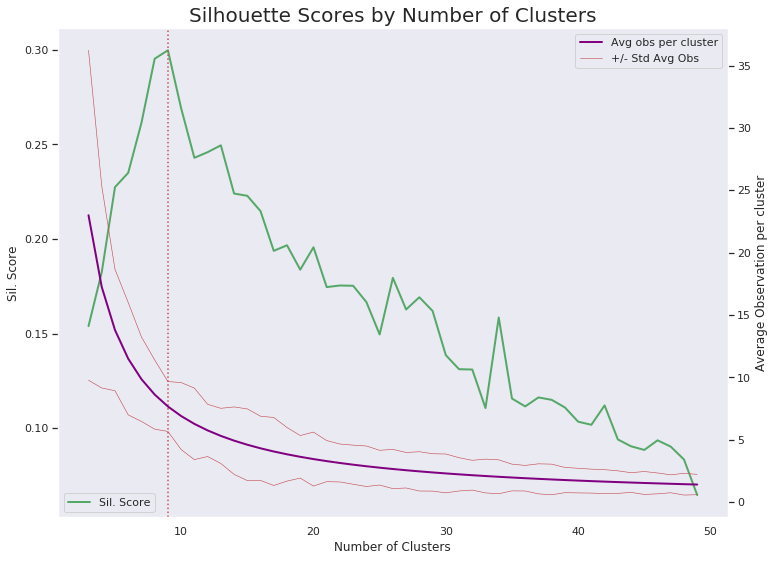

In [30]:
#Visualize Results
fobsstd1 = [ i+j for i,j in zip(favgobs,fobsstd)]
fstdneg = [ i-j for i,j in zip(favgobs,fobsstd)]

sns.set(context='notebook', style='dark')
fig, ax = fig, ax = plt.subplots(figsize=(12,9))

ax2 = ax.twinx()
ax = sns.lineplot(fnclusts, fsscores,color='g', label='Sil. Score', linewidth=2, ax=ax)
ax2 =sns.lineplot(fnclusts, favgobs,color='purple',label='Avg obs per cluster', linewidth=2)
sns.lineplot(fnclusts,fobsstd1,color='r',label='+/- Std Avg Obs', linewidth=.6)
sns.lineplot(fnclusts,fstdneg,color='r', linewidth=.6)

ax.set_ylabel('Sil. Score')
ax.set_xlabel('Number of Clusters')
ax.axvline(x=9,color='r',linestyle='dotted')


ax.legend(loc='lower left')
ax2.legend(loc='upper right')
plt.ylabel('Average Observation per cluster')
plt.xlabel('Number of Clusters')
plt.title('Silhouette Scores by Number of Clusters',fontsize=20)
#
plt.savefig("silscores.png")

The silhouette scores indicates that that the optimal number of clusters is 9. This intuetivly makes sense. We have 10 subjects and 11 professors. It makes even more sense when we consider other facts about the data. For instance, the Natural Language Processing lectures are taught by Manning and Socher or that Strang has a linear algebra series and a mechanical engineering series in the lectures. We will examine the clusters and try to determine how the cluster assignments are given. We will look at possible cluster number candidates 9, 10 and 11.  9, because it was the highest score in the silhouette analysis. 10 because there are 10 subjects and 11, because there are 11 profressors.

### Reduce dimensionality of Doc2Vec sentences with PCA and t-SNE
    Reduce the dimensionality of the data, while keeping the cluster assignment and plot the results

#### PCA and TSNE with 9,10,11 Clusters

In [32]:
# instantiate the PCA module with two components so we can visualize the results
pca = PCA(n_components=2, random_state=43)

#create dataframe for plotting, add comoonents,labels
pca_plot = pd.DataFrame()
pca_plot['original'] = X_train
pca_plot['Professor'] = y_train[:,1]
pca_plot['Subject'] = y_train[:,2]
pca_plot['filename'] = y_train[:,0]

#get cluster assignments from KMeans Clustering
d2v_clusters9 = cluster.KMeans(n_clusters=9, random_state=43).fit_predict(vecs)
d2v_clusters10 = cluster.KMeans(n_clusters=10, random_state=43).fit_predict(vecs)
d2v_clusters11 = cluster.KMeans(n_clusters=11, random_state=43).fit_predict(vecs)
pca_plot['clusters9'] = d2v_clusters9
pca_plot['clusters10'] = d2v_clusters10
pca_plot['clusters11'] = d2v_clusters11
#fit transform doc2vec word vectors append to DF for plotting
Y = pca.fit_transform(vecs)
pca_plot['PCA_1'] = Y[:,0]
pca_plot['PCA_2'] = Y[:,1]
# calculate and print silhouette average scores
print('\nSilhouette Score 9 Clusters: {}'.format(silhouette_score(vecs, d2v_clusters9, metric='cosine')))
print('\nSilhouette Score 10 Clusters {}'.format(silhouette_score(vecs, d2v_clusters10, metric='cosine')))
print('\nSilhouette Score 11 Clusters {}'.format(silhouette_score(vecs, d2v_clusters11, metric='cosine')))
# instantiate the t-SNE module with two components so we can visualize the results
tsne = TSNE(n_components=2, random_state=43)
#create dataframe for plotting, add comoonents,labels
tsne_plot = pd.DataFrame()
tsne_plot['original'] = X_train
tsne_plot['Professor'] = y_train[:,1]
tsne_plot['Subject'] = y_train[:,2]
tsne_plot['filename'] = y_train[:,0]

#get cluster assignments from KMeans
d2v_clusterst9 = cluster.KMeans(n_clusters=9, random_state=43).fit_predict(vecs)
d2v_clusterst10 = cluster.KMeans(n_clusters=10, random_state=43).fit_predict(vecs) 
d2v_clusterst11 = cluster.KMeans(n_clusters=11, random_state=43).fit_predict(vecs) 
tsne_plot['clusters9'] = d2v_clusterst9
tsne_plot['clusters10'] = d2v_clusterst10
tsne_plot['clusters11'] = d2v_clusterst11
#fit transform doc2vec word vectors
Yt = tsne.fit_transform(vecs)
tsne_plot['TSNE_1'] = Yt[:,0]
tsne_plot['TSNE_2'] = Yt[:,1]


Silhouette Score 9 Clusters: 0.2997858595958776

Silhouette Score 10 Clusters 0.2691162644223933

Silhouette Score 11 Clusters 0.24296398516265033


In [66]:
tsne_plot[tsne_plot.Professor == 'Winston']

,original,Professor,Subject,filename,clusters,TSNE_1,TSNE_2
1,professor welcome 6034 know deal microphone ...,Winston,AI,winstonai1,9,95.685242,10.228790
10,professor well kodo drummers be group 30 40 j...,Winston,AI,winstonai10,9,80.911377,-6.723948
25,professor lady gentleman engineer drinking son...,Winston,AI,winstonai3,9,92.845154,16.436197
26,what go talk today goal so way little warm exe...,Winston,AI,winstonai2,9,74.337013,11.875367
33,professor many maybe work search problem hand ...,Winston,AI,winstonai7,9,99.976204,6.081642
57,professor today go talk search know go turn b...,Winston,AI,winstonai4,9,83.548279,29.779541


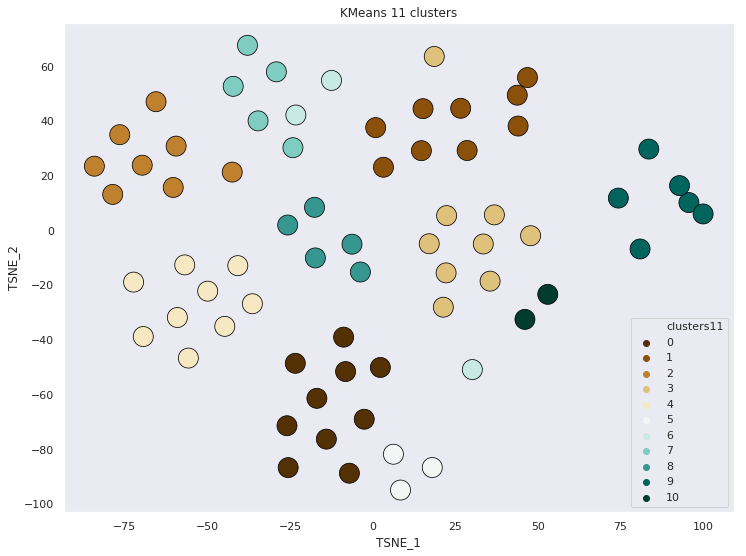

In [33]:
sns.set_context('notebook')
sns.set_style('dark')
plt.figure(figsize=(12,9))
sns.despine(left=True)

sns.scatterplot(x='TSNE_1', y='TSNE_2', hue='clusters11', data=tsne_plot, palette='BrBG', legend='full',
                edgecolor='black', s=400).set_title('KMeans 11 clusters')
plt.legend(loc='lower right')
plt.show()

### Actual Labels

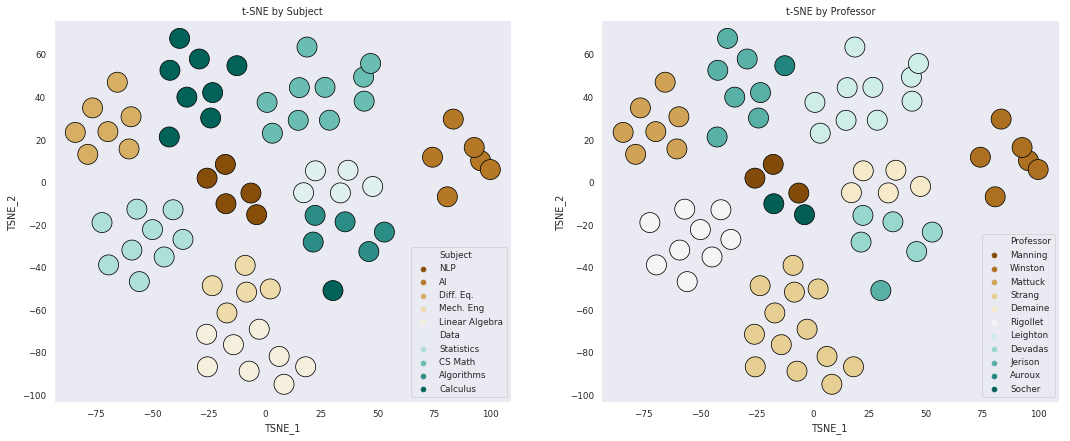

In [34]:
#Plot reduce data with subject and professor groupings
sns.set_context('paper')
f, axes = plt.subplots(1, 2, figsize=(18,7), sharex=False)
sns.despine(left=True)

sns.scatterplot(x='TSNE_1', y='TSNE_2', hue='Subject', data=tsne_plot, palette='BrBG', legend='full',
                edgecolor='black', s=400, ax=axes[0]).set_title('t-SNE by Subject')
sns.scatterplot(x='TSNE_1', y='TSNE_2', hue='Professor', data=tsne_plot, palette='BrBG', legend='full',
                edgecolor='black', s=400, ax=axes[1]).set_title('t-SNE by Professor')
plt.legend(loc='lower right')

plt.show()

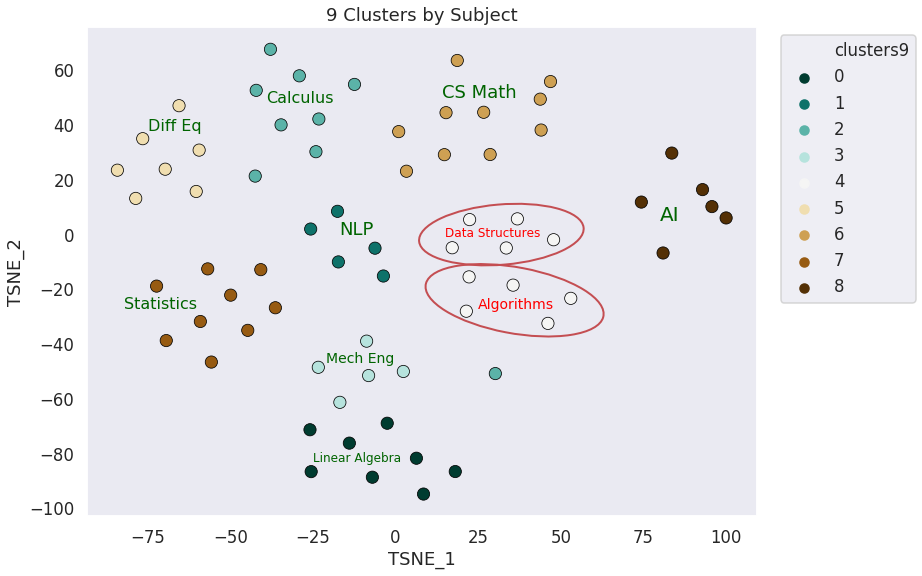

In [35]:
sns.set(style='dark', context='talk')
plt.figure(figsize=(12,9))
ax = sns.scatterplot(x='TSNE_1', 
                y='TSNE_2', 
                hue='clusters9',
                data=tsne_plot,
                palette='BrBG_r',
                legend='full',
                alpha=1,
                edgecolor='black',
                s=150)
plt.legend(loc='upper right', bbox_to_anchor=[1.25,1])
datas = patches.Ellipse((32,0),50,22,linewidth=2,edgecolor='r',facecolor='none', angle=6)
algos = patches.Ellipse((36,-24),55,24,linewidth=2,edgecolor='r',facecolor='none', angle=-13)
# Add the patch to the Axes

ax.add_patch(datas)
ax.add_patch(algos)

#for label, x, y in zip(ltsned2v33.original,ltsned2v33.TSNE_1,ltsned2v33.TSNE_2):
plt.annotate("CS Math", xy=(14, 50), xytext=(0, 0), color='darkgreen', textcoords='offset points',fontsize=18)
plt.annotate("NLP", xy=(-17, 0), xytext=(0, 0), color='darkgreen', textcoords='offset points',fontsize=18)
plt.annotate("Data Structures", xy=(15, -1), xytext=(0, 0), color='red', textcoords='offset points',fontsize=12)
plt.annotate("Algorithms", xy=(25, -27), xytext=(0, 0), color='red', textcoords='offset points',fontsize=14)
plt.annotate("AI", xy=(80, 5), xytext=(0, 0), color='darkgreen', textcoords='offset points',fontsize=20)
plt.annotate("Calculus", xy=(-39, 48), xytext=(0, 0), color='darkgreen', textcoords='offset points',fontsize=16)
plt.annotate("Diff Eq", xy=(-75, 38), xytext=(0, 0), color='darkgreen', textcoords='offset points',fontsize=16)
plt.annotate("Statistics", xy=(-82, -27), xytext=(0, 0), color='darkgreen', textcoords='offset points',fontsize=16)
plt.annotate("Mech Eng", xy=(-21, -47), xytext=(0, 0), color='darkgreen', textcoords='offset points',fontsize=14)
plt.annotate("Linear Algebra", xy=(-25, -83), xytext=(0, 0), color='darkgreen', textcoords='offset points',fontsize=12)
# label the axes and set the chart title  
plt.title("9 Clusters by Subject")   
plt.show()

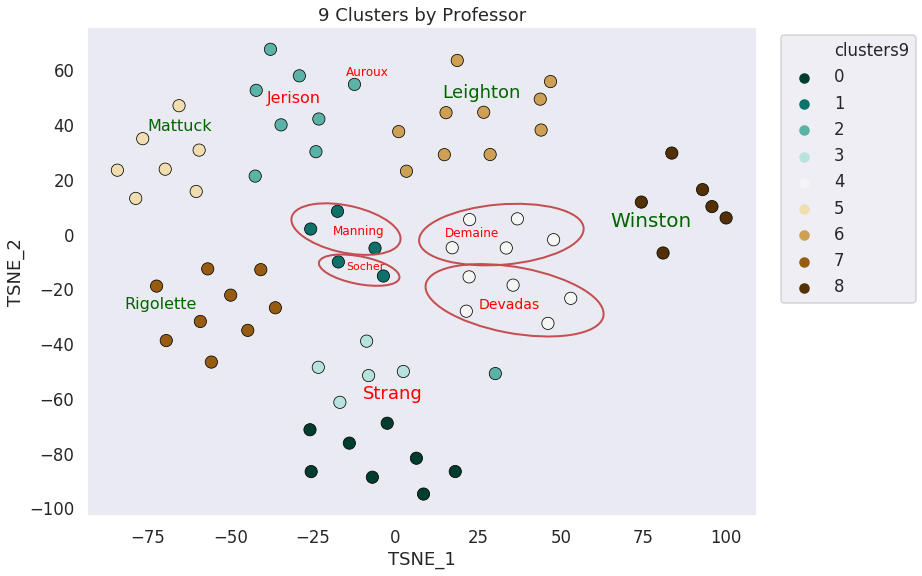

In [36]:
sns.set(style='dark', context='talk')
plt.figure(figsize=(12,9))
ax = sns.scatterplot(x='TSNE_1', 
                y='TSNE_2', 
                hue='clusters9',
                data=tsne_plot,
                palette='BrBG_r',
                legend='full',
                alpha=1,
                edgecolor='black',
                s=150)
plt.legend(loc='upper right', bbox_to_anchor=[1.25,1])
datas = patches.Ellipse((32,0),50,22,linewidth=2,edgecolor='r',facecolor='none', angle=6)
algos = patches.Ellipse((36,-24),55,24,linewidth=2,edgecolor='r',facecolor='none', angle=-13)
socher= patches.Ellipse((-11,-13),25,10,linewidth=2,edgecolor='r',facecolor='none', angle=-14)
manning = patches.Ellipse((-15,2),34,17,linewidth=2,edgecolor='r',facecolor='none', angle=-16)

# Add the patch to the Axes

ax.add_patch(datas)
ax.add_patch(algos)
ax.add_patch(socher)
ax.add_patch(manning)

#for label, x, y in zip(ltsned2v33.original,ltsned2v33.TSNE_1,ltsned2v33.TSNE_2):
plt.annotate("Leighton", xy=(14, 50), xytext=(0, 0), color='darkgreen', textcoords='offset points',fontsize=18)
plt.annotate("Manning", xy=(-19, 0), xytext=(0, 0), color='red', textcoords='offset points',fontsize=12)
plt.annotate("Socher", xy=(-15, -13), xytext=(0, 0), color='red', textcoords='offset points',fontsize=11)
plt.annotate("Demaine", xy=(15, -1), xytext=(0, 0), color='red', textcoords='offset points',fontsize=12)
plt.annotate("Devadas", xy=(25, -27), xytext=(0, 0), color='red', textcoords='offset points',fontsize=14)
plt.annotate("Winston", xy=(65, 3), xytext=(0, 0), color='darkgreen', textcoords='offset points',fontsize=20)
plt.annotate("Jerison", xy=(-39, 48), xytext=(0, 0), color='red', textcoords='offset points',fontsize=16)
plt.annotate("Mattuck", xy=(-75, 38), xytext=(0, 0), color='darkgreen', textcoords='offset points',fontsize=16)
plt.annotate("Rigolette", xy=(-82, -27), xytext=(0, 0), color='darkgreen', textcoords='offset points',fontsize=16)
plt.annotate("Strang", xy=(-10, -60), xytext=(0, 0), color='red', textcoords='offset points',fontsize=18)
plt.annotate("Auroux", xy=(-15, 58), xytext=(0, 0), color='red', textcoords='offset points',fontsize=12)


# label the axes and set the chart title  
plt.title("9 Clusters by Professor")   
plt.show()

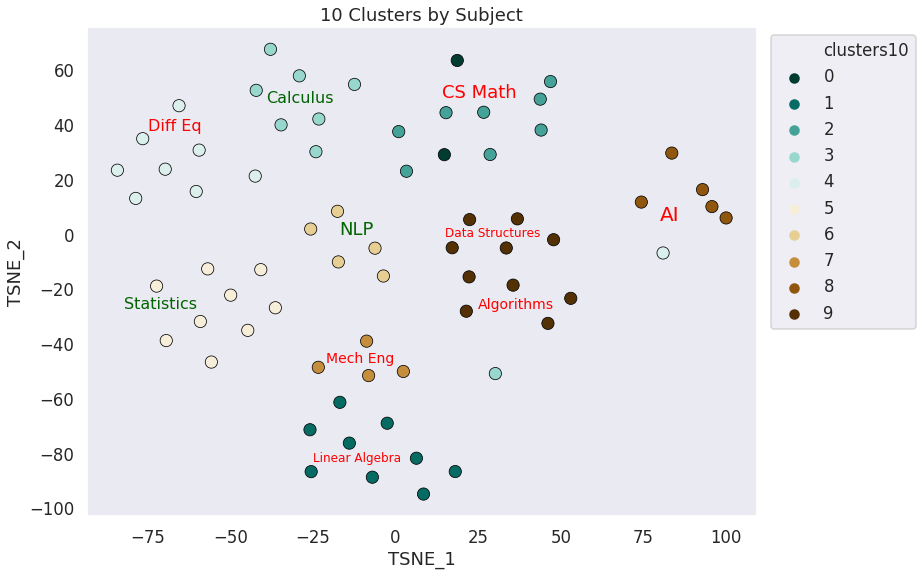

In [37]:
sns.set(style='dark', context='talk')
plt.figure(figsize=(12,9))
ax = sns.scatterplot(x='TSNE_1', 
                y='TSNE_2', 
                hue='clusters10',
                data=tsne_plot,
                palette='BrBG_r',
                legend='full',
                alpha=1,
                edgecolor='black',
                s=150)
plt.legend(loc='upper right', bbox_to_anchor=[1.25,1])
#datas = patches.Ellipse((32,0),50,22,linewidth=2,edgecolor='r',facecolor='none', angle=6)
#algos = patches.Ellipse((36,-24),55,24,linewidth=2,edgecolor='r',facecolor='none', angle=-13)
# Add the patch to the Axes

#ax.add_patch(datas)
#ax.add_patch(algos)

#for label, x, y in zip(ltsned2v33.original,ltsned2v33.TSNE_1,ltsned2v33.TSNE_2):
plt.annotate("CS Math", xy=(14, 50), xytext=(0, 0), color='red', textcoords='offset points',fontsize=18)
plt.annotate("NLP", xy=(-17, 0), xytext=(0, 0), color='darkgreen', textcoords='offset points',fontsize=18)
plt.annotate("Data Structures", xy=(15, -1), xytext=(0, 0), color='red', textcoords='offset points',fontsize=12)
plt.annotate("Algorithms", xy=(25, -27), xytext=(0, 0), color='red', textcoords='offset points',fontsize=14)
plt.annotate("AI", xy=(80, 5), xytext=(0, 0), color='red', textcoords='offset points',fontsize=20)
plt.annotate("Calculus", xy=(-39, 48), xytext=(0, 0), color='darkgreen', textcoords='offset points',fontsize=16)
plt.annotate("Diff Eq", xy=(-75, 38), xytext=(0, 0), color='red', textcoords='offset points',fontsize=16)
plt.annotate("Statistics", xy=(-82, -27), xytext=(0, 0), color='darkgreen', textcoords='offset points',fontsize=16)
plt.annotate("Mech Eng", xy=(-21, -47), xytext=(0, 0), color='red', textcoords='offset points',fontsize=14)
plt.annotate("Linear Algebra", xy=(-25, -83), xytext=(0, 0), color='red', textcoords='offset points',fontsize=12)
# label the axes and set the chart title  
plt.title("10 Clusters by Subject")   
plt.show()

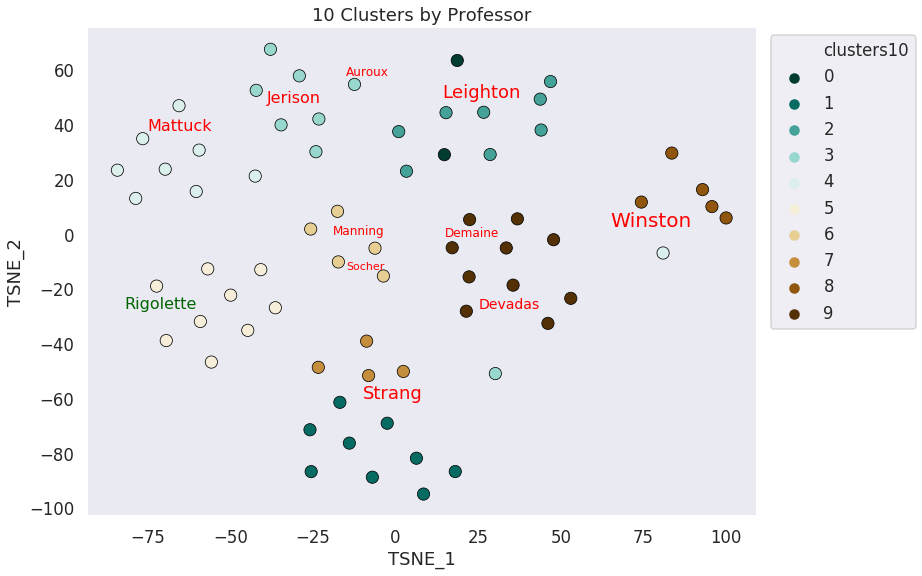

In [38]:
sns.set(style='dark', context='talk')
plt.figure(figsize=(12,9))
ax = sns.scatterplot(x='TSNE_1', 
                y='TSNE_2', 
                hue='clusters10',
                data=tsne_plot,
                palette='BrBG_r',
                legend='full',
                alpha=1,
                edgecolor='black',
                s=150)
plt.legend(loc='upper right', bbox_to_anchor=[1.25,1])
#datas = patches.Ellipse((32,0),50,22,linewidth=2,edgecolor='r',facecolor='none', angle=6)
#algos = patches.Ellipse((36,-24),55,24,linewidth=2,edgecolor='r',facecolor='none', angle=-13)
#socher= patches.Ellipse((-11,-13),25,10,linewidth=2,edgecolor='r',facecolor='none', angle=-14)
#manning = patches.Ellipse((-15,2),34,17,linewidth=2,edgecolor='r',facecolor='none', angle=-16)

# Add the patch to the Axes

#ax.add_patch(datas)
#ax.add_patch(algos)
#ax.add_patch(socher)
#ax.add_patch(manning)

#for label, x, y in zip(ltsned2v33.original,ltsned2v33.TSNE_1,ltsned2v33.TSNE_2):
plt.annotate("Leighton", xy=(14, 50), xytext=(0, 0), color='red', textcoords='offset points',fontsize=18)
plt.annotate("Manning", xy=(-19, 0), xytext=(0, 0), color='red', textcoords='offset points',fontsize=12)
plt.annotate("Socher", xy=(-15, -13), xytext=(0, 0), color='red', textcoords='offset points',fontsize=11)
plt.annotate("Demaine", xy=(15, -1), xytext=(0, 0), color='red', textcoords='offset points',fontsize=12)
plt.annotate("Devadas", xy=(25, -27), xytext=(0, 0), color='red', textcoords='offset points',fontsize=14)
plt.annotate("Winston", xy=(65, 3), xytext=(0, 0), color='red', textcoords='offset points',fontsize=20)
plt.annotate("Jerison", xy=(-39, 48), xytext=(0, 0), color='red', textcoords='offset points',fontsize=16)
plt.annotate("Mattuck", xy=(-75, 38), xytext=(0, 0), color='red', textcoords='offset points',fontsize=16)
plt.annotate("Rigolette", xy=(-82, -27), xytext=(0, 0), color='darkgreen', textcoords='offset points',fontsize=16)
plt.annotate("Strang", xy=(-10, -60), xytext=(0, 0), color='red', textcoords='offset points',fontsize=18)
plt.annotate("Auroux", xy=(-15, 58), xytext=(0, 0), color='red', textcoords='offset points',fontsize=12)
# label the axes and set the chart title  
plt.title("10 Clusters by Professor")   
plt.show()

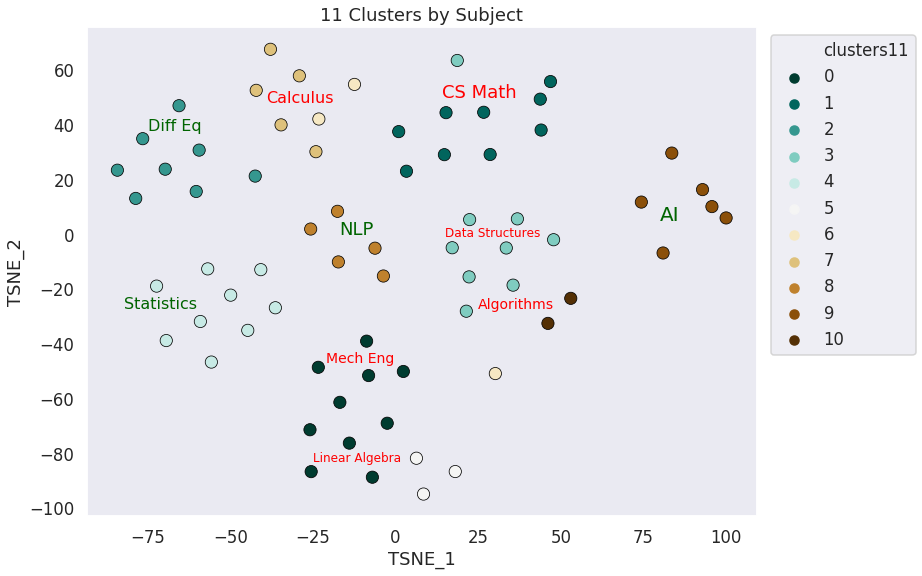

In [39]:
sns.set(style='dark', context='talk')
plt.figure(figsize=(12,9))
ax = sns.scatterplot(x='TSNE_1', 
                y='TSNE_2', 
                hue='clusters11',
                data=tsne_plot,
                palette='BrBG_r',
                legend='full',
                alpha=1,
                edgecolor='black',
                s=150)
plt.legend(loc='upper right', bbox_to_anchor=[1.25,1])
#datas = patches.Ellipse((32,0),50,22,linewidth=2,edgecolor='r',facecolor='none', angle=6)
#algos = patches.Ellipse((36,-24),55,24,linewidth=2,edgecolor='r',facecolor='none', angle=-13)
# Add the patch to the Axes

#ax.add_patch(datas)
#ax.add_patch(algos)

#for label, x, y in zip(ltsned2v33.original,ltsned2v33.TSNE_1,ltsned2v33.TSNE_2):
plt.annotate("CS Math", xy=(14, 50), xytext=(0, 0), color='red', textcoords='offset points',fontsize=18)
plt.annotate("NLP", xy=(-17, 0), xytext=(0, 0), color='darkgreen', textcoords='offset points',fontsize=18)
plt.annotate("Data Structures", xy=(15, -1), xytext=(0, 0), color='red', textcoords='offset points',fontsize=12)
plt.annotate("Algorithms", xy=(25, -27), xytext=(0, 0), color='red', textcoords='offset points',fontsize=14)
plt.annotate("AI", xy=(80, 5), xytext=(0, 0), color='darkgreen', textcoords='offset points',fontsize=20)
plt.annotate("Calculus", xy=(-39, 48), xytext=(0, 0), color='red', textcoords='offset points',fontsize=16)
plt.annotate("Diff Eq", xy=(-75, 38), xytext=(0, 0), color='darkgreen', textcoords='offset points',fontsize=16)
plt.annotate("Statistics", xy=(-82, -27), xytext=(0, 0), color='darkgreen', textcoords='offset points',fontsize=16)
plt.annotate("Mech Eng", xy=(-21, -47), xytext=(0, 0), color='red', textcoords='offset points',fontsize=14)
plt.annotate("Linear Algebra", xy=(-25, -83), xytext=(0, 0), color='red', textcoords='offset points',fontsize=12)
# label the axes and set the chart title  
plt.title("11 Clusters by Subject")   
plt.show()

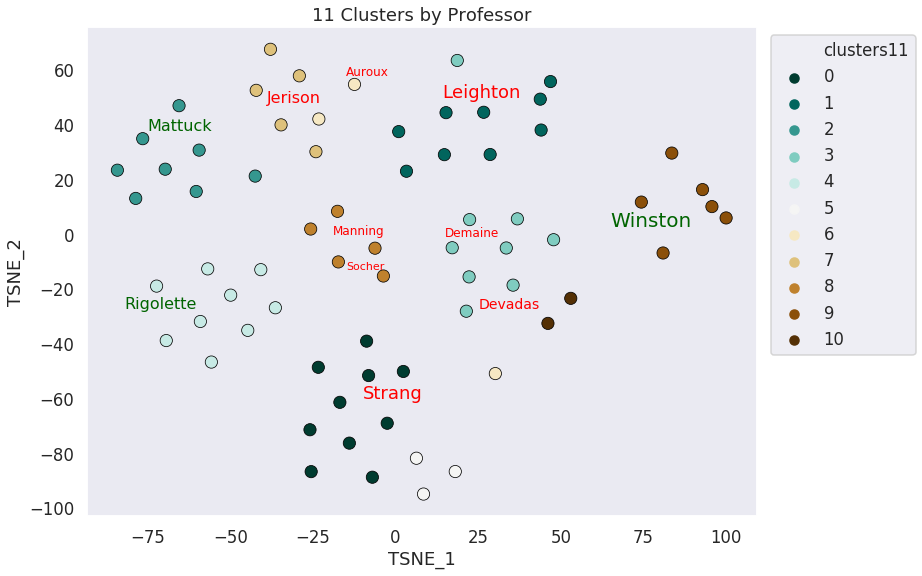

In [40]:
sns.set(style='dark', context='talk')
plt.figure(figsize=(12,9))
ax = sns.scatterplot(x='TSNE_1', 
                y='TSNE_2', 
                hue='clusters11',
                data=tsne_plot,
                palette='BrBG_r',
                legend='full',
                alpha=1,
                edgecolor='black',
                s=150)
plt.legend(loc='upper right', bbox_to_anchor=[1.25,1])
#datas = patches.Ellipse((32,0),50,22,linewidth=2,edgecolor='r',facecolor='none', angle=6)
#algos = patches.Ellipse((36,-24),55,24,linewidth=2,edgecolor='r',facecolor='none', angle=-13)
#socher= patches.Ellipse((-11,-13),25,10,linewidth=2,edgecolor='r',facecolor='none', angle=-14)
#manning = patches.Ellipse((-15,2),34,17,linewidth=2,edgecolor='r',facecolor='none', angle=-16)

# Add the patch to the Axes

#ax.add_patch(datas)
#ax.add_patch(algos)
#ax.add_patch(socher)
#ax.add_patch(manning)

#for label, x, y in zip(ltsned2v33.original,ltsned2v33.TSNE_1,ltsned2v33.TSNE_2):
plt.annotate("Leighton", xy=(14, 50), xytext=(0, 0), color='red', textcoords='offset points',fontsize=18)
plt.annotate("Manning", xy=(-19, 0), xytext=(0, 0), color='red', textcoords='offset points',fontsize=12)
plt.annotate("Socher", xy=(-15, -13), xytext=(0, 0), color='red', textcoords='offset points',fontsize=11)
plt.annotate("Demaine", xy=(15, -1), xytext=(0, 0), color='red', textcoords='offset points',fontsize=12)
plt.annotate("Devadas", xy=(25, -27), xytext=(0, 0), color='red', textcoords='offset points',fontsize=14)
plt.annotate("Winston", xy=(65, 3), xytext=(0, 0), color='darkgreen', textcoords='offset points',fontsize=20)
plt.annotate("Jerison", xy=(-39, 48), xytext=(0, 0), color='red', textcoords='offset points',fontsize=16)
plt.annotate("Mattuck", xy=(-75, 38), xytext=(0, 0), color='darkgreen', textcoords='offset points',fontsize=16)
plt.annotate("Rigolette", xy=(-82, -27), xytext=(0, 0), color='darkgreen', textcoords='offset points',fontsize=16)
plt.annotate("Strang", xy=(-10, -60), xytext=(0, 0), color='red', textcoords='offset points',fontsize=18)
plt.annotate("Auroux", xy=(-15, 58), xytext=(0, 0), color='red', textcoords='offset points',fontsize=12)
# label the axes and set the chart title  
plt.title("11 Clusters by Professor")   
plt.show()

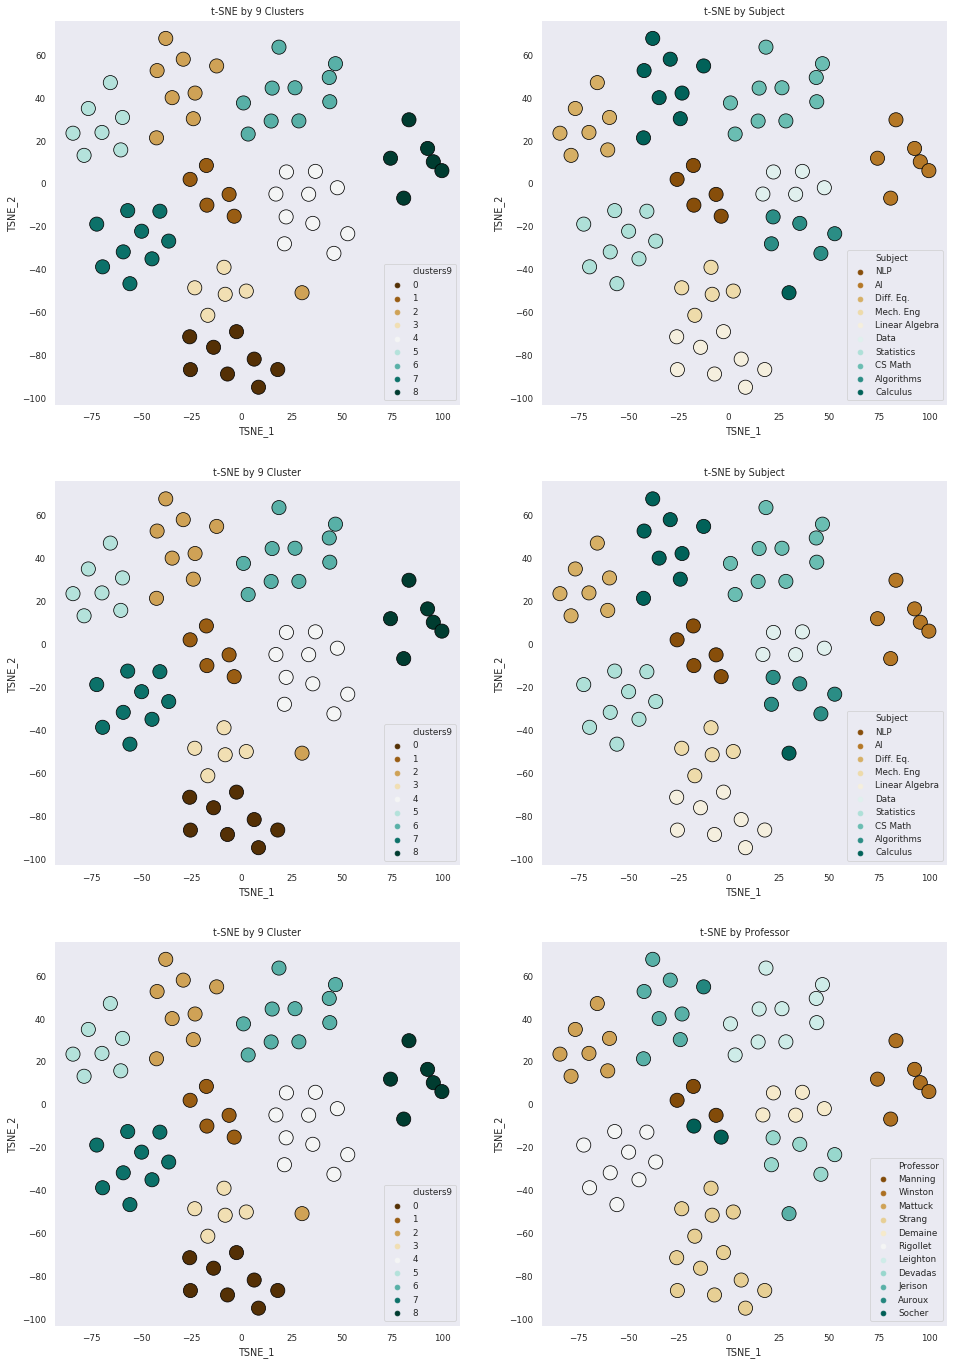

In [41]:
sns.set_context('paper')
f, axes = plt.subplots(3, 2, figsize=(16, 24), sharex=False)
sns.despine(left=True)
sns.scatterplot(x='TSNE_1', y='TSNE_2', hue='clusters9', data=tsne_plot, palette='BrBG', legend='full',
                edgecolor='black', s=200, ax=axes[0, 0]).set_title('t-SNE by 9 Clusters')
sns.scatterplot(x='TSNE_1', y='TSNE_2', hue='Subject', data=tsne_plot, palette='BrBG', legend='full',
                edgecolor='black', s=200, ax=axes[0, 1]).set_title('t-SNE by Subject')

sns.scatterplot(x='TSNE_1', y='TSNE_2', hue='clusters9', data=tsne_plot, palette='BrBG', legend='full',
                edgecolor='black', s=200, ax=axes[1, 0]).set_title('t-SNE by 9 Cluster')
sns.scatterplot(x='TSNE_1', y='TSNE_2', hue='Subject', data=tsne_plot, palette='BrBG', legend='full',
                edgecolor='black', s=200, ax=axes[1, 1]).set_title('t-SNE by Subject')

sns.scatterplot(x='TSNE_1', y='TSNE_2', hue='clusters9', data=tsne_plot, palette='BrBG', legend='full',
                edgecolor='black', s=200, ax=axes[2, 0]).set_title('t-SNE by 9 Cluster')
sns.scatterplot(x='TSNE_1', y='TSNE_2', hue='Professor', data=tsne_plot, palette='BrBG', legend='full',
                edgecolor='black', s=200, ax=axes[2, 1]).set_title('t-SNE by Professor')



plt.show()


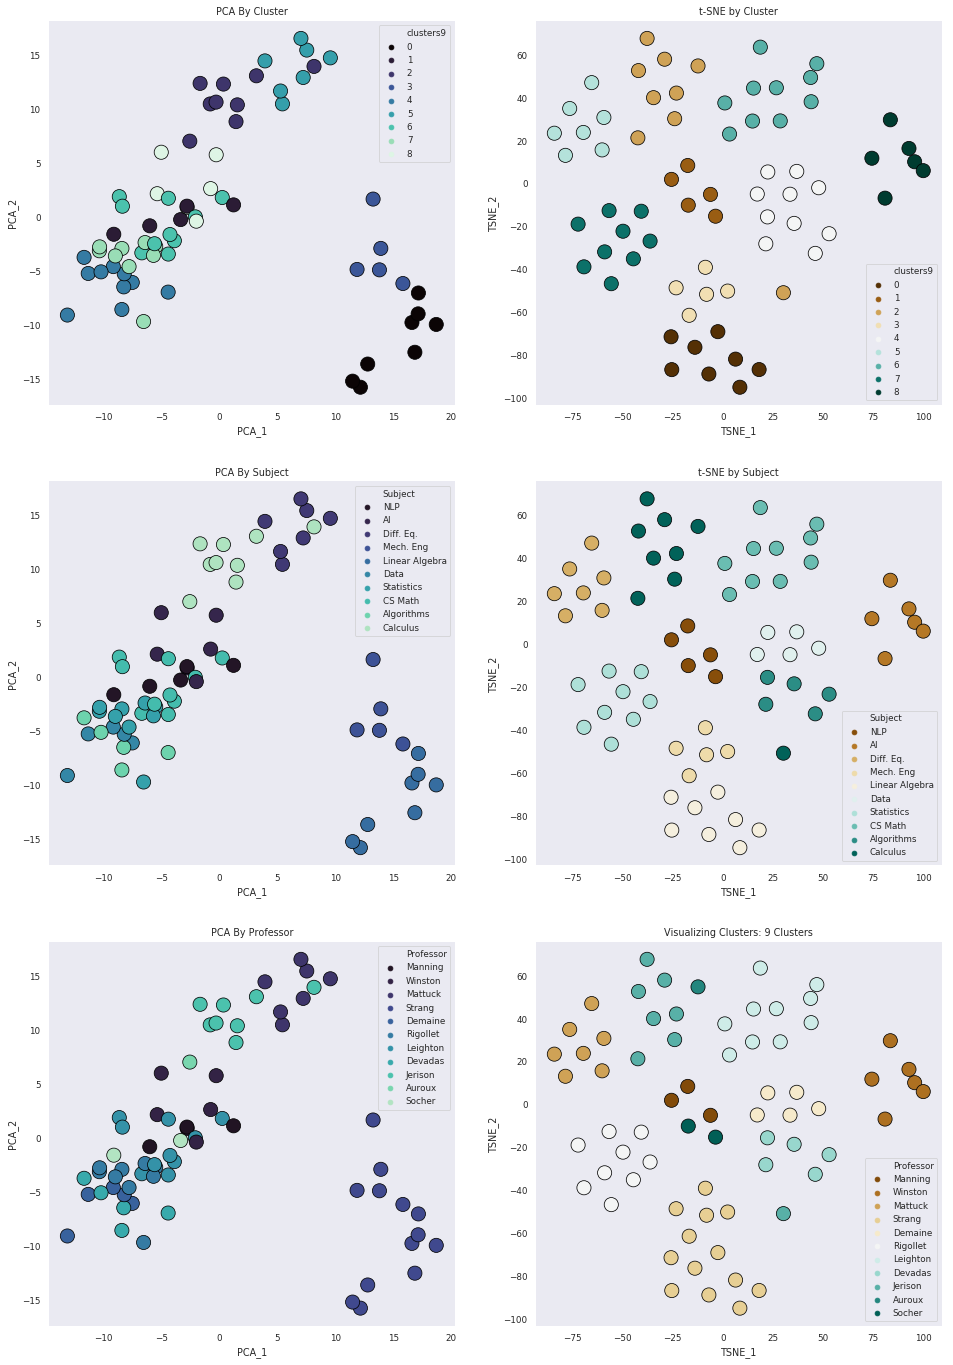

In [43]:
sns.set_context('paper')
f, axes = plt.subplots(3, 2, figsize=(16, 24), sharex=False)
sns.despine(left=True)
sns.scatterplot(x='PCA_1', y='PCA_2', hue='clusters9', data=pca_plot,palette='mako', legend='full',
            s=200, edgecolor='black', ax=axes[0, 0]).set_title("PCA By Cluster")
sns.scatterplot(x='PCA_1', y='PCA_2', hue='Subject', data=pca_plot,palette='mako', legend='full',
            s=200, edgecolor='black', ax=axes[1, 0]).set_title("PCA By Subject")
sns.scatterplot(x='PCA_1', y='PCA_2', hue='Professor', data=pca_plot,palette='mako', legend='full',
            s=200, edgecolor='black', ax=axes[2, 0]).set_title("PCA By Professor")
sns.scatterplot(x='TSNE_1', y='TSNE_2', hue='clusters9', data=tsne_plot, palette='BrBG', legend='full',
                edgecolor='black', s=200, ax=axes[0, 1]).set_title('t-SNE by Cluster')
sns.scatterplot(x='TSNE_1', y='TSNE_2', hue='Subject', data=tsne_plot, palette='BrBG', legend='full',
                edgecolor='black', s=200, ax=axes[1, 1]).set_title('t-SNE by Subject')
sns.scatterplot(x='TSNE_1', y='TSNE_2', hue='Professor', data=tsne_plot, palette='BrBG', legend='full',
                edgecolor='black', s=200, ax=axes[2, 1]).set_title('t-SNE by Professor')
plt.title('Visualizing Clusters: 9 Clusters')
plt.show()


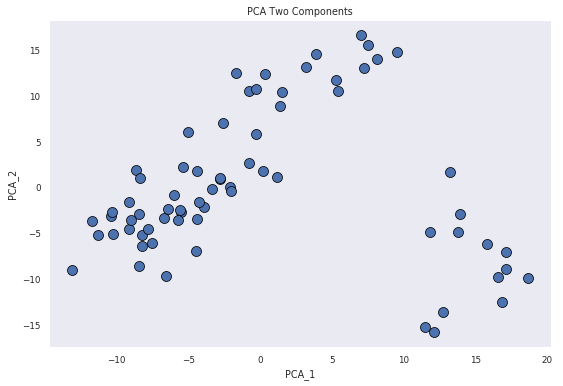

In [47]:
plt.figure(figsize=(9,6))
sns.scatterplot(x='PCA_1', y='PCA_2', data=pca_plot,palette='mako', legend=False,
            s=100, edgecolor='black').set_title("PCA Two Components")
plt.show()

#### PCA and TSNE with 10 Clusters


Silhouette Score 0.2691162644223933
Number of Clusters: 10


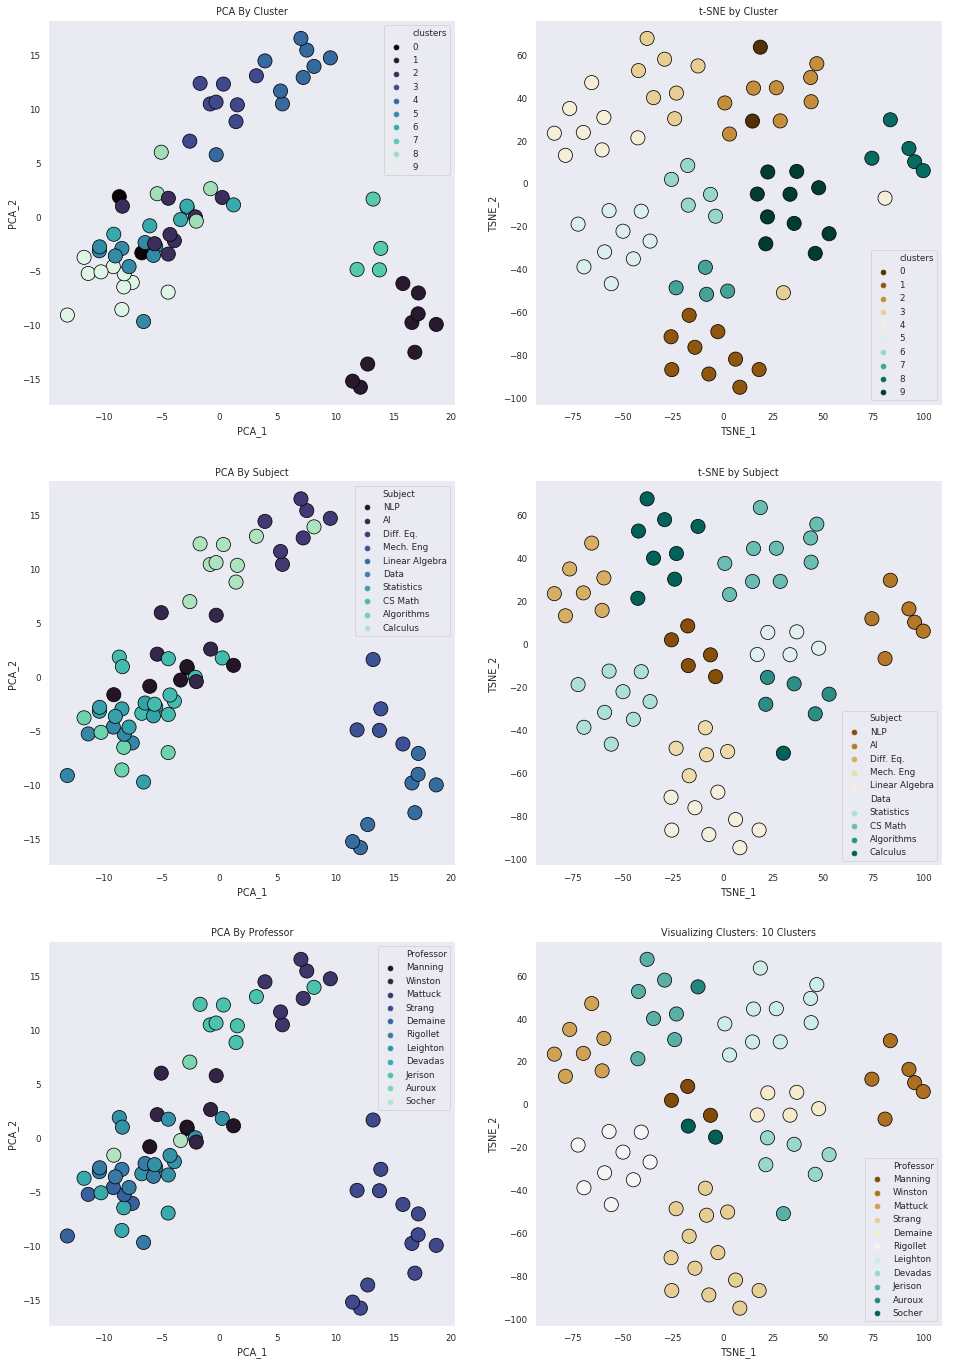

In [48]:
# instantiate the PCA module with two components so we can visualize the results
pca = PCA(n_components=2, random_state=43)

#create dataframe for plotting, add comoonents,labels
pca_plot = pd.DataFrame()
pca_plot['original'] = X_train
pca_plot['Professor'] = y_train[:,1]
pca_plot['Subject'] = y_train[:,2]
pca_plot['filename'] = y_train[:,0]

#get cluster assignments from KMeans Clustering
d2v_clusters = cluster.KMeans(n_clusters=10, random_state=43).fit_predict(vecs) 
pca_plot['clusters'] = d2v_clusters
#fit transform doc2vec word vectors append to DF for plotting
Y = pca.fit_transform(vecs)
pca_plot['PCA_1'] = Y[:,0]
pca_plot['PCA_2'] = Y[:,1]
# calculate and print silhouette average scores
print('\nSilhouette Score {}'.format(silhouette_score(vecs, d2v_clusters, metric='cosine')))

# instantiate the t-SNE module with two components so we can visualize the results
tsne = TSNE(n_components=2, random_state=43)
#create dataframe for plotting, add comoonents,labels
tsne_plot = pd.DataFrame()
tsne_plot['original'] = X_train
tsne_plot['Professor'] = y_train[:,1]
tsne_plot['Subject'] = y_train[:,2]
tsne_plot['filename'] = y_train[:,0]

#get cluster assignments from KMeans
d2v_clusterst = cluster.KMeans(n_clusters=10, random_state=43).fit_predict(vecs) 
tsne_plot['clusters'] = d2v_clusterst
#fit transform doc2vec word vectors
Yt = tsne.fit_transform(vecs)
tsne_plot['TSNE_1'] = Yt[:,0]
tsne_plot['TSNE_2'] = Yt[:,1]
print('Number of Clusters: 10')
# calculate and print silhouette average scores
sns.set_context('paper')
f, axes = plt.subplots(3, 2, figsize=(16, 24), sharex=False)
sns.despine(left=True)
sns.scatterplot(x='PCA_1', y='PCA_2', hue='clusters', data=pca_plot,palette='mako', legend='full',
            s=200, edgecolor='black', ax=axes[0, 0]).set_title("PCA By Cluster")
sns.scatterplot(x='PCA_1', y='PCA_2', hue='Subject', data=pca_plot,palette='mako', legend='full',
            s=200, edgecolor='black', ax=axes[1, 0]).set_title("PCA By Subject")
sns.scatterplot(x='PCA_1', y='PCA_2', hue='Professor', data=pca_plot,palette='mako', legend='full',
            s=200, edgecolor='black', ax=axes[2, 0]).set_title("PCA By Professor")
sns.scatterplot(x='TSNE_1', y='TSNE_2', hue='clusters', data=tsne_plot, palette='BrBG', legend='full',
                edgecolor='black', s=200, ax=axes[0, 1]).set_title('t-SNE by Cluster')
sns.scatterplot(x='TSNE_1', y='TSNE_2', hue='Subject', data=tsne_plot, palette='BrBG', legend='full',
                edgecolor='black', s=200, ax=axes[1, 1]).set_title('t-SNE by Subject')
sns.scatterplot(x='TSNE_1', y='TSNE_2', hue='Professor', data=tsne_plot, palette='BrBG', legend='full',
                edgecolor='black', s=200, ax=axes[2, 1]).set_title('t-SNE by Professor')
plt.title('Visualizing Clusters: 10 Clusters')
plt.show()


### Agglomerative Clustering

Damping : 3

Silhouette Score 0.15508534527766146


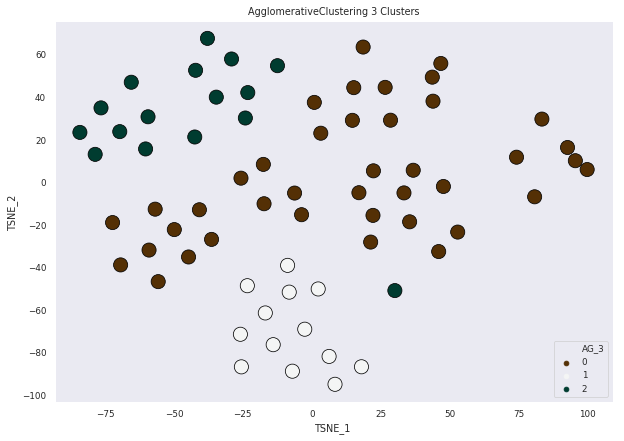

Damping : 4

Silhouette Score 0.19472622695338887


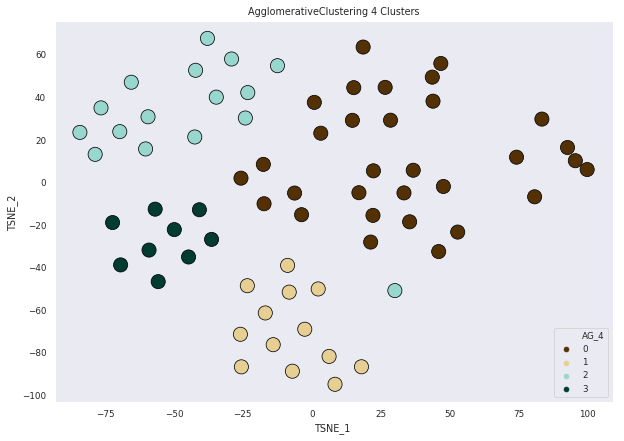

Damping : 5

Silhouette Score 0.22668460454370495


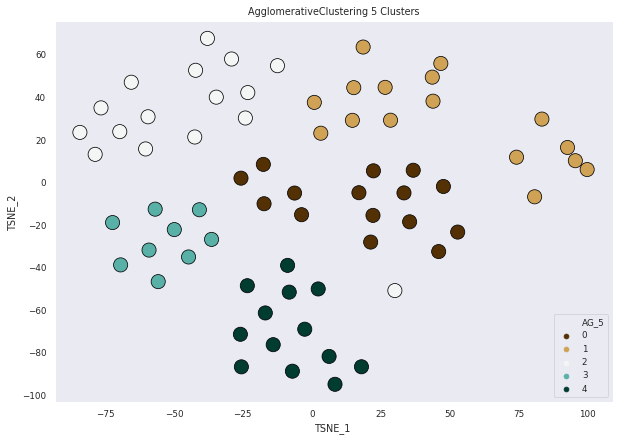

Damping : 6

Silhouette Score 0.261167334158765


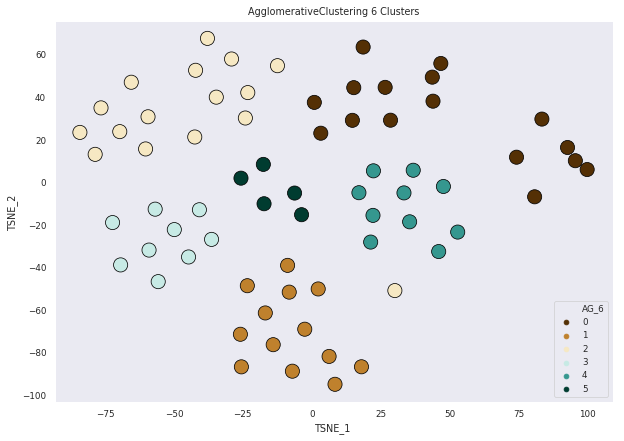

Damping : 7

Silhouette Score 0.28320554722973024


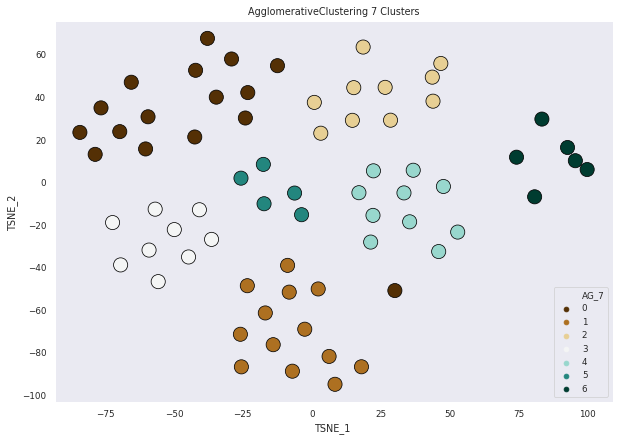

Damping : 8

Silhouette Score 0.2966711412290417


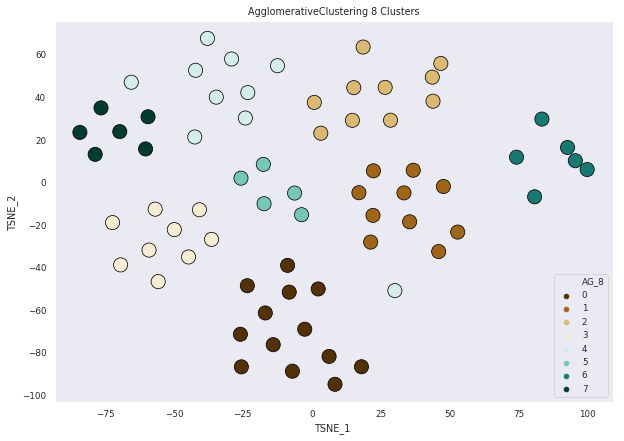

Damping : 9

Silhouette Score 0.2903520721189839


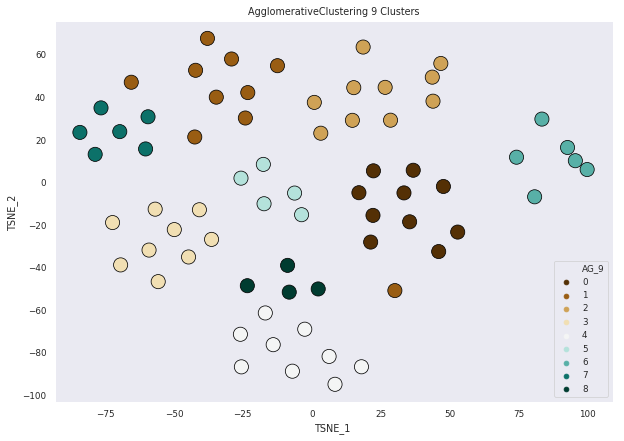

Damping : 10

Silhouette Score 0.27721368839881727


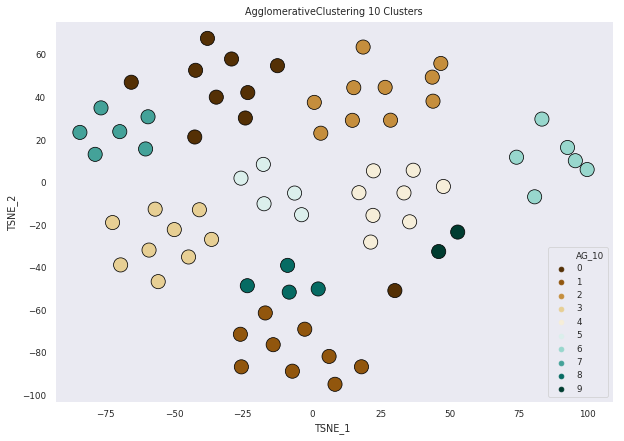

Damping : 11

Silhouette Score 0.27323675652893237


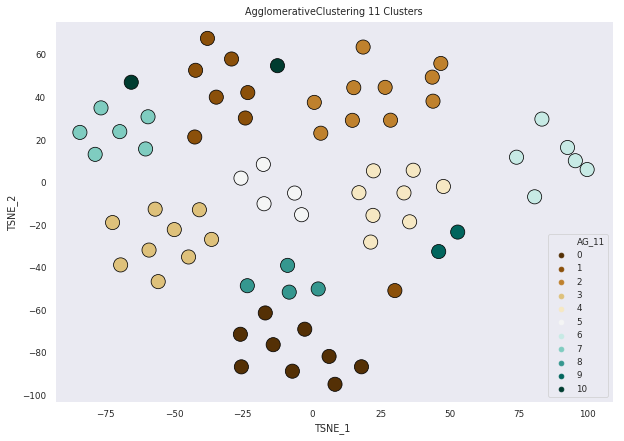

In [49]:
cluts = range(3,12,1)
for i in cluts:
    ag = cluster.AgglomerativeClustering(linkage='ward', n_clusters=i)
    ag.fit(vecs)
    labels3 = ag.labels_
    print('Damping : {}'.format(i))
    print('\nSilhouette Score {}'.format(silhouette_score(vecs, labels3, metric='cosine')))
    plt.figure(figsize=(10,7))

    tsne_plot['AG_'+str(i)] = labels3

    sns.scatterplot(x='TSNE_1',
                    y='TSNE_2', 
                    hue='AG_'+str(i), 
                    data=tsne_plot,
                    palette='BrBG',
                    legend='full',
                    edgecolor='black',
                    s=200)
    plt.legend(loc='lower right')
    plt.title('AgglomerativeClustering​ {} Clusters'.format(i))
    plt.show()

### Affinity Propagation

Damping : 0.8

number of Clusters: 10
Silhouette Score 0.265048303947724


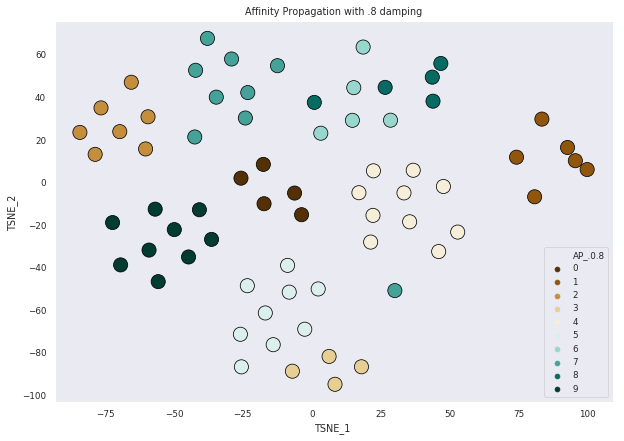

In [50]:
i=.80
af = cluster.AffinityPropagation(damping=i).fit(vecs)
cluster_centers_indices = af.cluster_centers_indices_
n_clusters2_ = len(cluster_centers_indices)
labels2 = af.labels_

print('Damping : {}\n'.format(i))
print("number of Clusters: {}".format(len(cluster_centers_indices)))
print('Silhouette Score {}'.format(silhouette_score(vecs, labels2, metric='cosine')))
plt.figure(figsize=(10,7))

tsne_plot['AP_.'+str(i)] = labels2

sns.scatterplot(x='TSNE_1',
                y='TSNE_2', 
                hue='AP_.{}'.format(str(i)), 
                data=tsne_plot,
                palette='BrBG',
                legend='full',
                edgecolor='black',
                s=200)
plt.legend(loc='lower right')
plt.title('Affinity Propagation with .8 damping')
plt.show()



### Mean Shift

Number of estimated clusters: 1


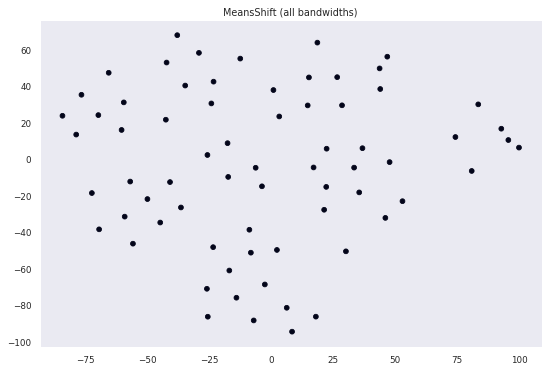

Comparing the assigned categories to the ones in the data:


In [47]:
bandwidth = cluster.estimate_bandwidth(vecs, quantile=.95, n_samples=500)
ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(vecs)    
labels1 = ms.labels_ # Extract cluster assignments for each data point.   
cluster_centers1 = ms.cluster_centers_  # Coordinates of the cluster centers.    
n_clusters1_ = len(np.unique(labels1)) # Count our clusters.
print("Number of estimated clusters: {}".format(n_clusters1_))  
plt.figure(figsize=(9,6))
plt.scatter(tsne_plot['TSNE_1'], tsne_plot['TSNE_2'], c=labels1)
plt.title("MeansShift (all bandwidths)")
plt.show()
print('Comparing the assigned categories to the ones in the data:')
#print(pd.crosstab(y_train,labels1))


Silhouette Score 0.24296398516265033
Number of Clusters: 11


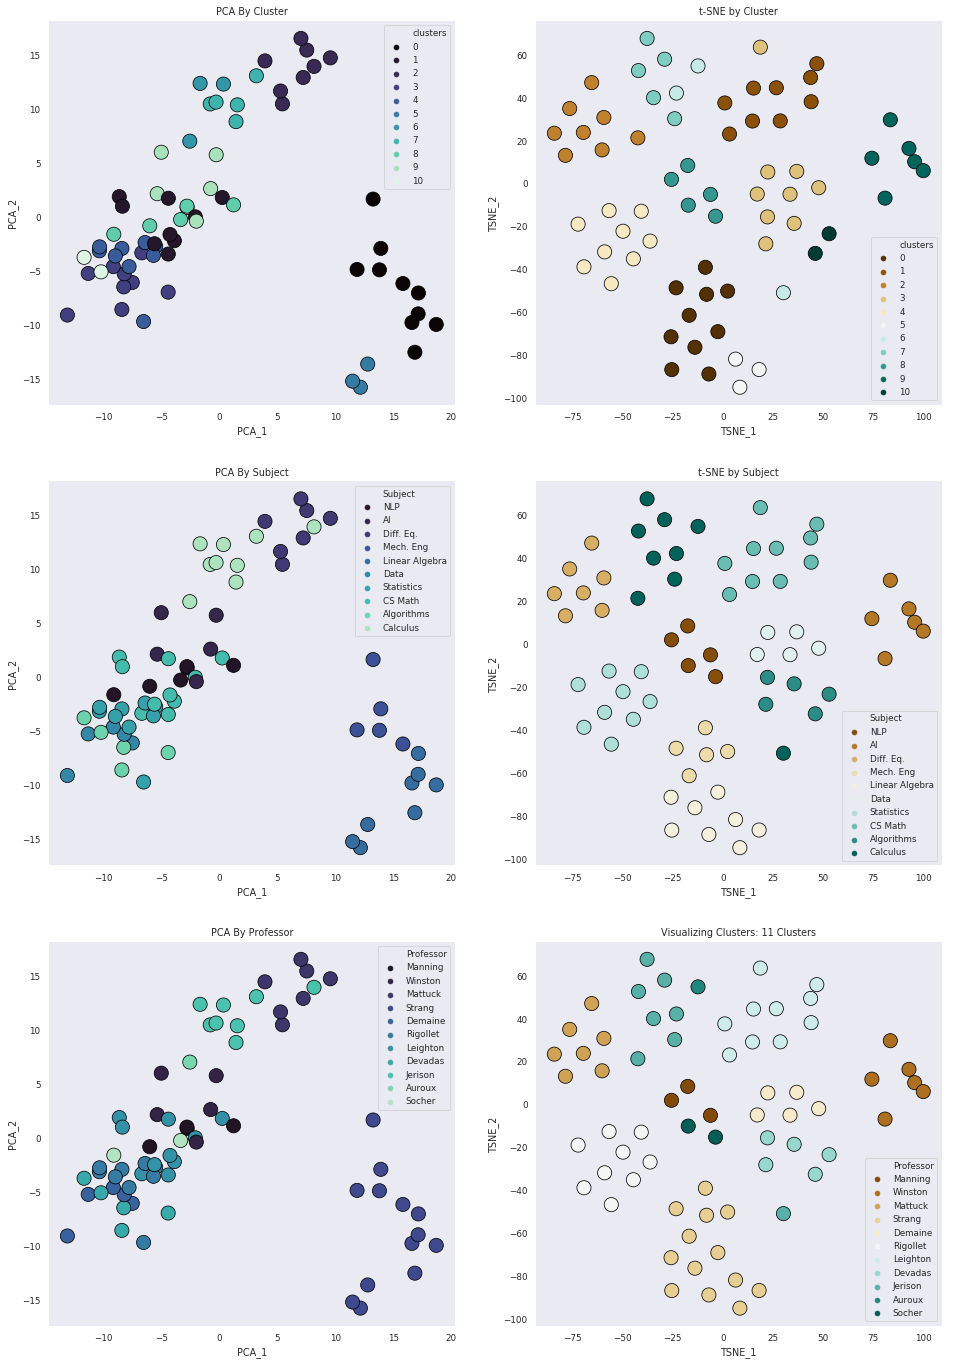

In [51]:
# instantiate the PCA module with two components so we can visualize the results
pca = PCA(n_components=2, random_state=43)

#create dataframe for plotting, add comoonents,labels
pca_plot = pd.DataFrame()
pca_plot['original'] = X_train
pca_plot['Professor'] = y_train[:,1]
pca_plot['Subject'] = y_train[:,2]
pca_plot['filename'] = y_train[:,0]

#get cluster assignments from KMeans Clustering
d2v_clusters = cluster.KMeans(n_clusters=11, random_state=43).fit_predict(vecs) 
pca_plot['clusters'] = d2v_clusters
#fit transform doc2vec word vectors append to DF for plotting
Y = pca.fit_transform(vecs)
pca_plot['PCA_1'] = Y[:,0]
pca_plot['PCA_2'] = Y[:,1]
# calculate and print silhouette average scores
print('\nSilhouette Score {}'.format(silhouette_score(vecs, d2v_clusters, metric='cosine')))

# instantiate the t-SNE module with two components so we can visualize the results
tsne = TSNE(n_components=2, random_state=43)
#create dataframe for plotting, add comoonents,labels
tsne_plot = pd.DataFrame()
tsne_plot['original'] = X_train
tsne_plot['Professor'] = y_train[:,1]
tsne_plot['Subject'] = y_train[:,2]
tsne_plot['filename'] = y_train[:,0]

#get cluster assignments from KMeans
d2v_clusterst = cluster.KMeans(n_clusters=11, random_state=43).fit_predict(vecs) 
tsne_plot['clusters'] = d2v_clusterst
#fit transform doc2vec word vectors
Yt = tsne.fit_transform(vecs)
tsne_plot['TSNE_1'] = Yt[:,0]
tsne_plot['TSNE_2'] = Yt[:,1]
print('Number of Clusters: 11')
# calculate and print silhouette average scores
sns.set_context('paper')
f, axes = plt.subplots(3, 2, figsize=(16, 24), sharex=False)
sns.despine(left=True)
sns.scatterplot(x='PCA_1', y='PCA_2', hue='clusters', data=pca_plot,palette='mako', legend='full',
            s=200, edgecolor='black', ax=axes[0, 0]).set_title("PCA By Cluster")
sns.scatterplot(x='PCA_1', y='PCA_2', hue='Subject', data=pca_plot,palette='mako', legend='full',
            s=200, edgecolor='black', ax=axes[1, 0]).set_title("PCA By Subject")
sns.scatterplot(x='PCA_1', y='PCA_2', hue='Professor', data=pca_plot,palette='mako', legend='full',
            s=200, edgecolor='black', ax=axes[2, 0]).set_title("PCA By Professor")
sns.scatterplot(x='TSNE_1', y='TSNE_2', hue='clusters', data=tsne_plot, palette='BrBG', legend='full',
                edgecolor='black', s=200, ax=axes[0, 1]).set_title('t-SNE by Cluster')
sns.scatterplot(x='TSNE_1', y='TSNE_2', hue='Subject', data=tsne_plot, palette='BrBG', legend='full',
                edgecolor='black', s=200, ax=axes[1, 1]).set_title('t-SNE by Subject')
sns.scatterplot(x='TSNE_1', y='TSNE_2', hue='Professor', data=tsne_plot, palette='BrBG', legend='full',
                edgecolor='black', s=200, ax=axes[2, 1]).set_title('t-SNE by Professor')
plt.title('Visualizing Clusters: 11 Clusters')
plt.show()


### Clustering with the PCA decomposition

In [52]:
# instantiate the Sklearn's PCA module with two components for graphing purposes
pca = PCA(n_components=2)
Yf = pca.fit_transform(vecs)

pca_fd2vclusters = pd.DataFrame()
pca_fd2vclusters['original'] = X_train
pca_fd2vclusters['Professor'] = y_train[:,0]
pca_fd2vclusters['Subject'] = y_train[:,1]
pca_fd2vclusters['PCA_1'] = Yf[:,0]
pca_fd2vclusters['PCA_2'] = Yf[:,1]
pca_fd2vclusters['filename'] = y_train[:,2]

Number of Clusters: 2

Silhouette Score 2 clusters: 0.5444843357679555




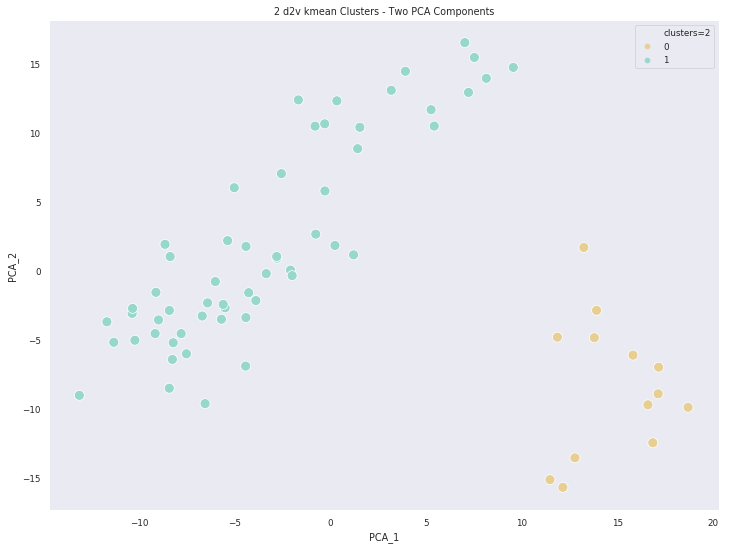


Avg Obs per cluster: 34.5

Number of observations per cluster:
1    56
0    13
dtype: int64
Time: 0.38317275047302246 seconds.

Number of Clusters: 4

Silhouette Score 4 clusters: 0.5667486498784501




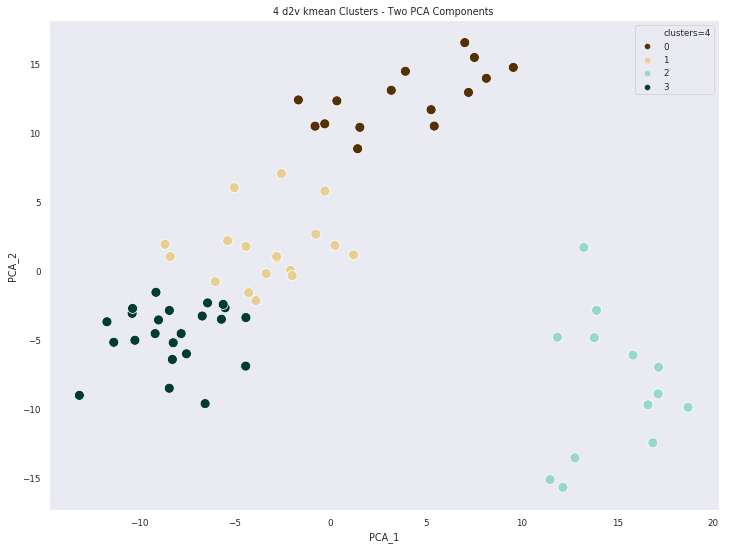


Avg Obs per cluster: 17.25

Number of observations per cluster:
3    23
1    18
0    15
2    13
dtype: int64
Time: 0.38860368728637695 seconds.

Number of Clusters: 6

Silhouette Score 6 clusters: 0.3791769155523347




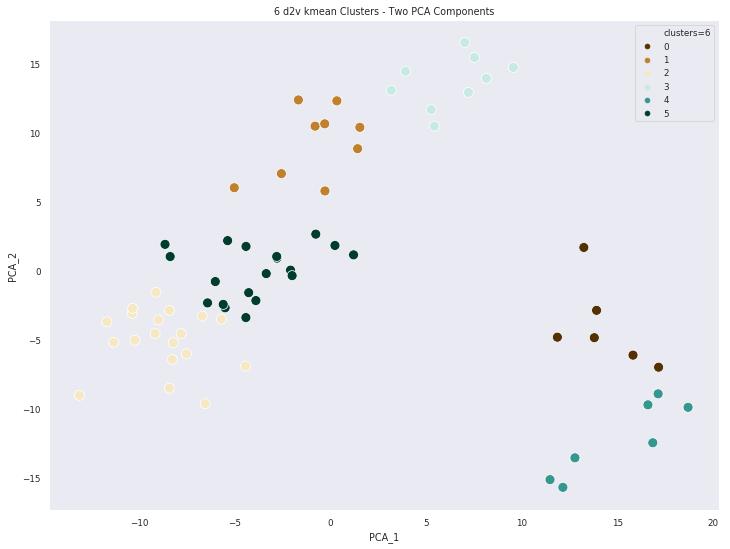


Avg Obs per cluster: 11.5

Number of observations per cluster:
5    19
2    19
3     9
1     9
4     7
0     6
dtype: int64
Time: 0.42392563819885254 seconds.

Number of Clusters: 8

Silhouette Score 8 clusters: 0.21158374800259877




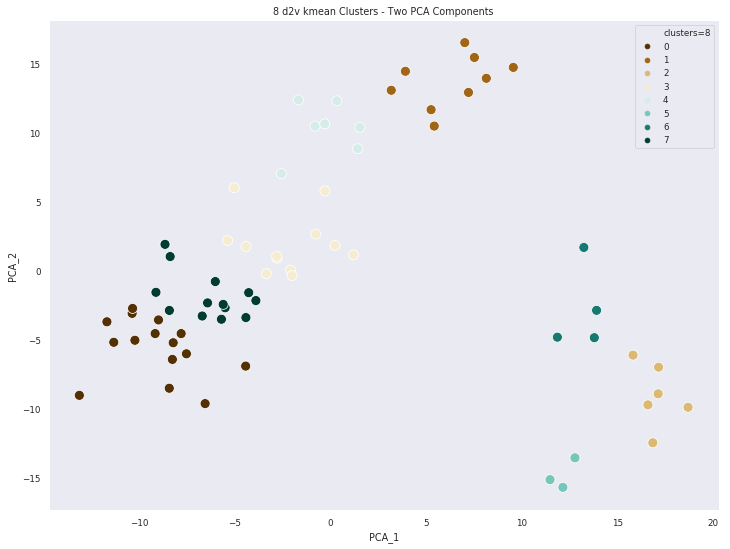


Avg Obs per cluster: 8.625

Number of observations per cluster:
0    15
7    13
3    12
1     9
4     7
2     6
6     4
5     3
dtype: int64
Time: 0.4291398525238037 seconds.

Number of Clusters: 10

Silhouette Score 10 clusters: 0.22001489575108532




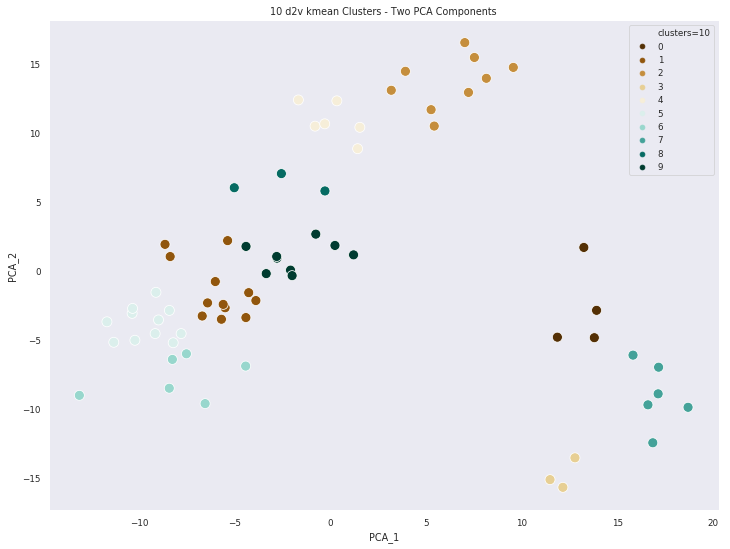


Avg Obs per cluster: 6.9

Number of observations per cluster:
1    12
5    11
9     9
2     9
7     6
6     6
4     6
0     4
8     3
3     3
dtype: int64
Time: 0.4681522846221924 seconds.

Number of Clusters: 12

Silhouette Score 12 clusters: 0.10422233939155556




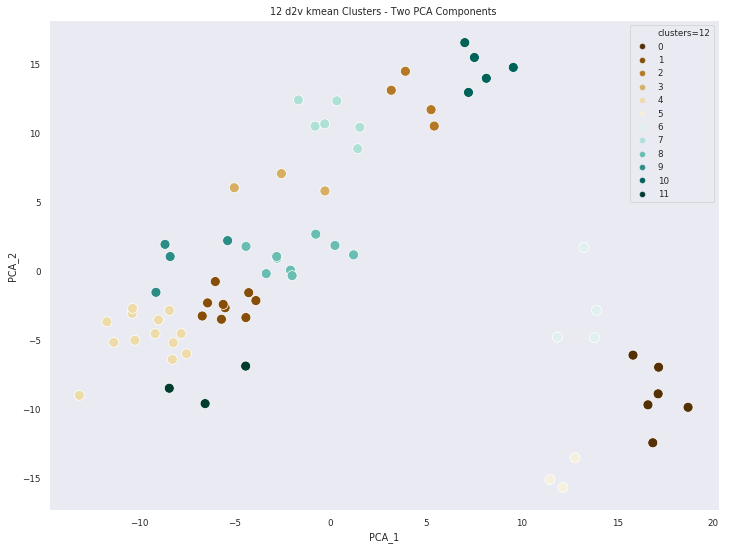


Avg Obs per cluster: 5.75

Number of observations per cluster:
4     13
8      9
1      9
7      6
0      6
10     5
9      4
6      4
2      4
11     3
5      3
3      3
dtype: int64
Time: 0.5451529026031494 seconds.

Number of Clusters: 14

Silhouette Score 14 clusters: 0.15598071667113864




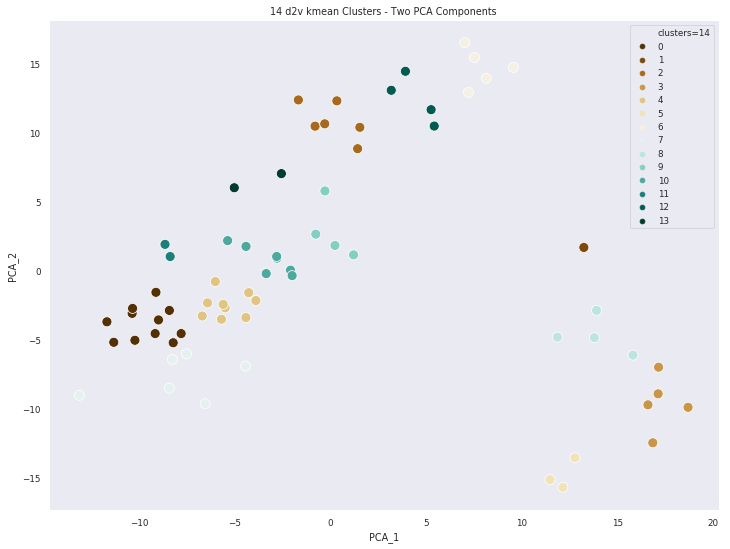


Avg Obs per cluster: 4.928571428571429

Number of observations per cluster:
0     11
4      9
10     7
7      6
2      6
6      5
3      5
12     4
9      4
8      4
5      3
13     2
dtype: int64
Time: 0.5453972816467285 seconds.



In [53]:
sns.set_context('paper')
d2v_fclusters = range(2,16,2)
for i in d2v_fclusters:
    t1 = time.time()
    d2v_fclusters = cluster.KMeans(n_clusters=i, random_state=43).fit_predict(Yf)    
    print('Number of Clusters: {}'.format(i))
    # calculate and print silhouette average scores
    print('\nSilhouette Score {} clusters:'.format(i), silhouette_score(Yf, d2v_fclusters, metric='cosine'))
    print('\n')
    pca_fd2vclusters['clusters='+str(i)] = d2v_fclusters
    plt.figure(figsize=(12,9))
    sns.scatterplot(x='PCA_1', y='PCA_2', hue='clusters='+str(i), data=pca_fd2vclusters,palette='BrBG',legend='full',s=100)
    plt.legend(loc='upper right')
    # label the axes and set the chart title  
    plt.title("{} d2v kmean Clusters - Two PCA Components".format(i))   
    plt.show()
    print("\nAvg Obs per cluster: {}\n".format(pd.value_counts(d2v_fclusters).mean()))
    print('Number of observations per cluster:')
    print(pd.value_counts(d2v_fclusters)[:12])    
    t2 = time.time()
    print("Time: {} seconds.\n".format(t2-t1))

Number of Clusters: 9

Silhouette Score 0.2691162644223933 clusters:




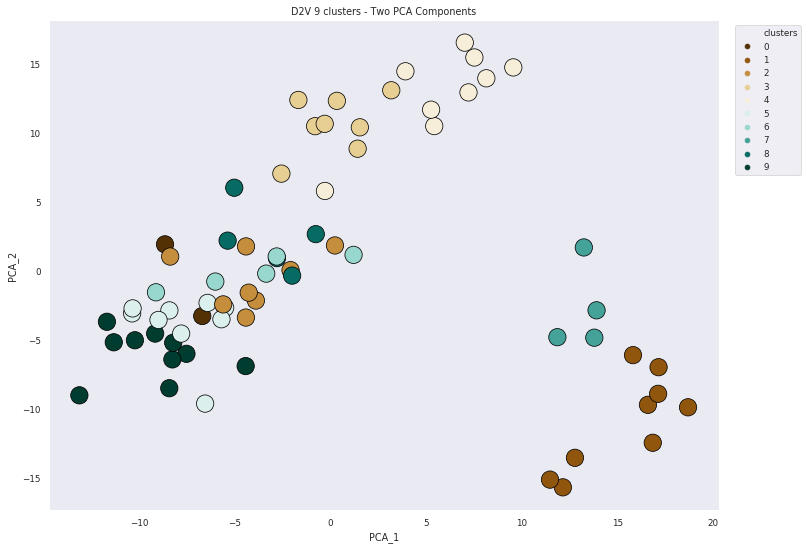

In [56]:
# instantiate the Sklearn's PCA module with two components for graphing purposes
pca = PCA(n_components=2, random_state=43)




#create dataframe for plotting, add comoonents,labels
pca_plot = pd.DataFrame()
pca_plot['original'] = X_train
pca_plot['Professor'] = y_train[:,1]
pca_plot['Subject'] = y_train[:,2]
pca_plot['filename'] = y_train[:,0]

#get cluster assignments from KMeans
d2v_clusters = cluster.KMeans(n_clusters=10, random_state=43).fit_predict(vecs) 

#fit transform doc2vec word vectors
Y = pca.fit_transform(vecs)
pca_plot['PCA_1'] = Y[:,0]
pca_plot['PCA_2'] = Y[:,1]
print('Number of Clusters: 9')
# calculate and print silhouette average scores
print('\nSilhouette Score {} clusters:'.format(silhouette_score(vecs, d2v_clusters, metric='cosine')))
print('\n')
sns.set(context='paper',style='dark')
pca_plot['clusters'] = d2v_clusters
plt.figure(figsize=(12,9))
sns.scatterplot(x='PCA_1', y='PCA_2', hue='clusters', data=pca_plot,palette='BrBG',legend='full',
                s=300, edgecolor='black')
plt.legend(loc='upper right', bbox_to_anchor=[1.13,1])
# label the axes and set the chart title  
plt.title("D2V 9 clusters - Two PCA Components")   
plt.show()

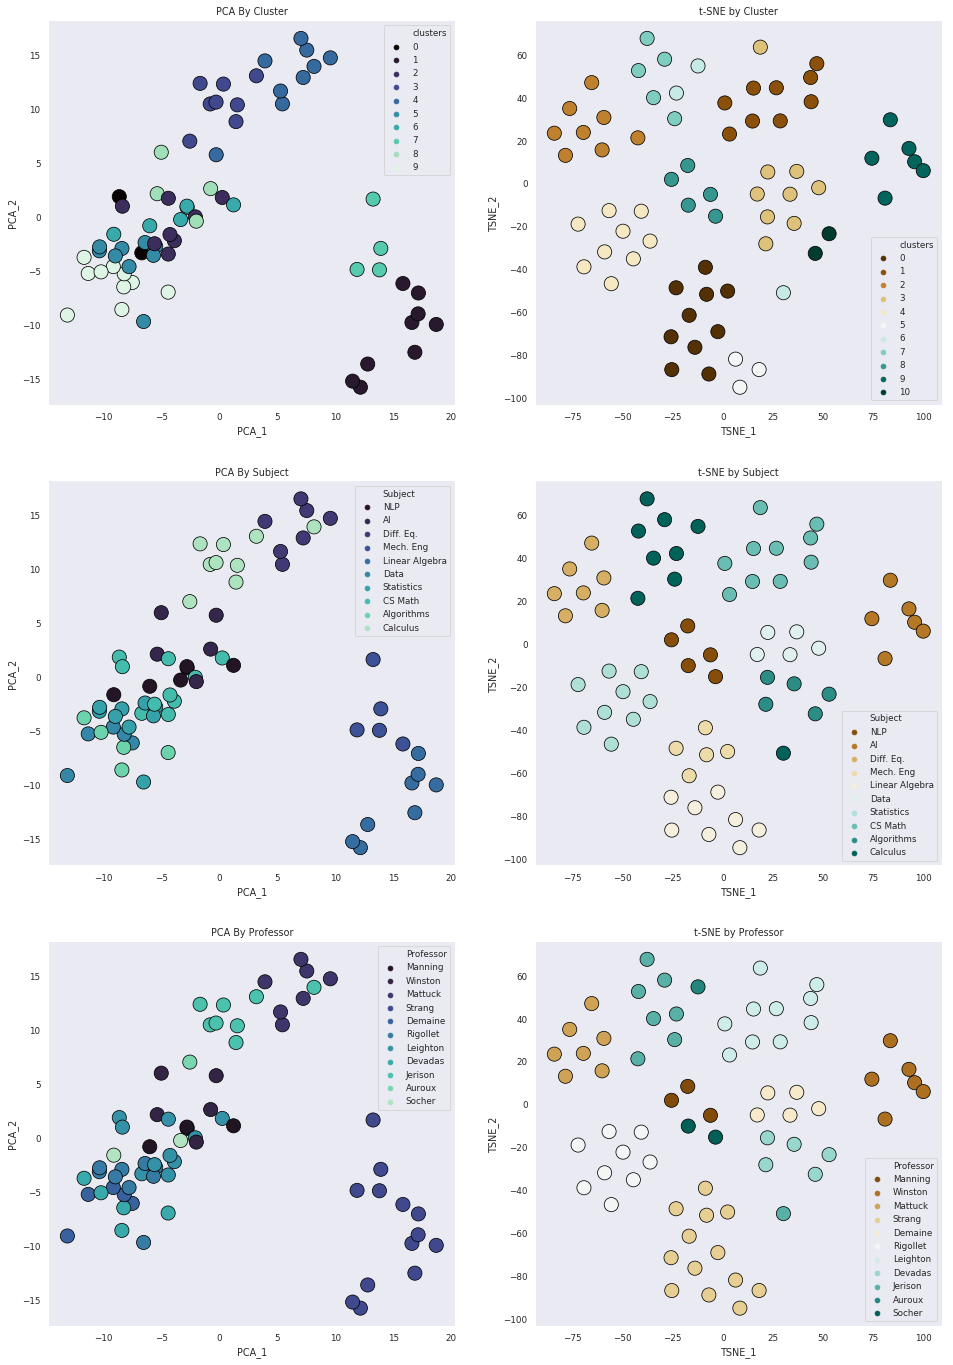

In [57]:
sns.set_context('paper')
f, axes = plt.subplots(3, 2, figsize=(16, 24), sharex=False)
sns.despine(left=True)
sns.scatterplot(x='PCA_1', y='PCA_2', hue='clusters', data=pca_plot,palette='mako', legend='full',
            s=200, edgecolor='black', ax=axes[0, 0]).set_title("PCA By Cluster")
sns.scatterplot(x='PCA_1', y='PCA_2', hue='Subject', data=pca_plot,palette='mako', legend='full',
            s=200, edgecolor='black', ax=axes[1, 0]).set_title("PCA By Subject")
sns.scatterplot(x='PCA_1', y='PCA_2', hue='Professor', data=pca_plot,palette='mako', legend='full',
            s=200, edgecolor='black', ax=axes[2, 0]).set_title("PCA By Professor")
sns.scatterplot(x='TSNE_1', y='TSNE_2', hue='clusters', data=tsne_plot, palette='BrBG', legend='full',
                edgecolor='black', s=200, ax=axes[0, 1]).set_title('t-SNE by Cluster')
sns.scatterplot(x='TSNE_1', y='TSNE_2', hue='Subject', data=tsne_plot, palette='BrBG', legend='full',
                edgecolor='black', s=200, ax=axes[1, 1]).set_title('t-SNE by Subject')
sns.scatterplot(x='TSNE_1', y='TSNE_2', hue='Professor', data=tsne_plot, palette='BrBG', legend='full',
                edgecolor='black', s=200, ax=axes[2, 1]).set_title('t-SNE by Professor')
plt.show()